# Russian Layout Optimization with Bigrams

In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_rows = 100
from math import floor
from collections import defaultdict

import colorsys
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyBboxPatch

# Contents

- [How this all works](#hiw)
- [How to test your layout](#how-to-test-your-layout)
- [Initialization and code](#init)
    - [Loading sample texts](#loading-texts)
        - [Some stats on bigrams](#some-stats)
    - [The code with the scoring rules](#scoring-code)
- [Comparing existing and my new layouts](#layouts)
- [Side-to-side comparisons of the best](#side-to-side)
- [Final standings](#standings)
- [Test your layout here](#your-layout)
    - [Compare with others](#compare)
    - [Output statistics in CSV](#output-statistics)
    - [Simple statistics of costs](#simple-stats)
    - [Where do letters want to move?](#letters-move)
- [Is Ergodox better?](#is-ergodox-better)
- [Heatmaps](#heatmaps)


## How This All Works <a name="hiw">

The code is organized in simple to use classes.
    
```
Corpus ------------------------------------------------> | Result
  .bigrams                                        /----> |   .score
                                                 /           .bigrams (w/ scores)
Keyboard ------------------>  Layout -----------/            .layout
  .keymap                       .keyboard                    .corpus
  (fingers & penalties)         .keymap
                                (keys w/ positions)
```

* `Corpus` stores bigrams dataframe, with frequencies and basic info about the letters for categorial analysis.
* `Keyboard` stores a dict: {(row, column): (finger, monogram penalty, ...)}
* To make a new Keyboard, provide it with fingers and penalties strings (see `STANDARD_KBD` and `ERGODOX` below).
* `Layout` takes keyboard, makes the dict a dataframe and adds keys to it.
* `Result` stores score and bigrams costs dataframes.
* `Result` can compare itself with another one, or better call `compare(results_dict, key1, key2)` to do things automatically.

## Testing Your Layout <a name="how-to-test-your-layout">

1. Run the cell with the code to make `CORP` and `STANDARD_KBD` (or another one).
1. Go to [Insert Your Layout](#your-layout) section.
2. Modify the layout, maintaining columns' positions, so that they match `STANDARD_KBD.fingers`.
3. Run the code & see the score.
4. Compare your layout to another one in the cells below that.

# Initialization and Code <a name="init">

In [2]:
# leter categories. V = vowel, C = consonant.
# nb: So-called "soft sign" Ь and "hard sign" Ъ are ancient vowels, and labelled as such.
LT = {'v': 'аеёиоуъыьэюя', 'c': 'бвгджзйклмнпрстфхцчшщ'}

# these keys MUST be in any layout, otherwise the code throws an exception and halts
BASE_KEYS = set('ё-!?%*():;йцукенгшщзхъфывапролджэячсмитьбю.,⌴¶')


class Corpus:
    def __init__(self, bigrams):
        self.bigrams = bigrams
        
    def from_string(raw_text):
        # we take text and encode it, replacing space, linebreak and tab with displayable surrogates.
        # (layouts are encoded with spaces and linebreaks as separators, so this way we won't confuse them)
        text = raw_text.lower().replace(' ', '⌴').replace('\n', '¶').replace('\t', '→')

        nums = defaultdict(int)
        for i in range(2, len(text)):
            nums[text[i-2:i]] += 1

        bigrams = pd.DataFrame(nums.items(), columns=['bigram', 'num'])
        bigrams['l1'] = bigrams.bigram.str[:1]
        bigrams['l2'] = bigrams.bigram.str[1:]
        for i in (1, 2):
            bigrams[f't{i}'] = bigrams[f'l{i}'].map(lambda l: 'v' if l.lower() in LT['v'] else ('c' if l.lower() in LT['c'] else '-'))       
        bigrams['freq'] = bigrams.num / bigrams.num.sum()
        return Corpus(bigrams)
        
    # simple function that reads the corpus and creates a bigram table.
    def from_path(path):
        """Reads file from path and calculates bigrams frequencies."""
        with open(path) as f:
            return Corpus.from_string(f.read())
    
    def display_outerness(self, filter_expr, left_hand=False):
        """Provide a `filter_expr` to filter the bigrams of the corpus,
        and this function will display a table and a plot with
        where a letter is more often in digrams in the subset.

        E.g. English S more often comes first among consonants.
        So it will be on the right (towards right hand pinky)."""
        d2 = self.bigrams[self.bigrams.eval(filter_expr)]
        t2 = d2.groupby('l1').agg({'freq': 'sum'}).join(d2.groupby('l2').agg({'freq': 'sum'}), how='outer', lsuffix='_out', rsuffix='_in')
        t2.fillna(0, inplace=True)
        t2['outer'] = - t2.freq_in + t2.freq_out
        t2['frequency'] = t2.freq_in + t2.freq_out
        t2['outerness'] = t2.outer / t2.frequency
        t2 *= 10000
        title = 'left hand: pinky <-> index' if left_hand else 'right hand: index <-> pinky'
        ax = t2[['frequency', 'outerness']].plot.scatter(x='outerness', y='frequency', title=title)
        for i, r in t2.iterrows():
            ax.annotate(i, (r.outerness + .1, r.frequency + .1))

        return t2.sort_values('outerness') # to readable numbers

## Loading Sample Texts <a name="loading-texts">

This is a sample from Strugatski brothers' "Inhabited Island" and Michail Bulgakov's "White Guard", roughly 500K of characters. Compared to my own texts assembled in 300K chars, some letters differ slightly: letter И (i) is much less popular. I don't know what to do with this.

In [3]:
CORP = Corpus.from_path('../sampletexts.txt')

# Some stats on bigrams <a name="some-stats">

## Vowels outer or inner?

Negative = wants more to be on outer keys, positive = more to inner.

In [4]:
CORP.bigrams

bigram   num l1 l2 t1 t2      freq
0        ¶м    47  ¶  м  -  c  0.000120
1        мо  1366  м  о  c  v  0.003489
2        ож   804  о  ж  v  c  0.002054
3        же  1119  ж  е  c  v  0.002858
4        ет  1997  е  т  v  c  0.005101
...     ...   ... .. .. .. ..       ...
2487     яи     1  я  и  v  v  0.000003
2488     ыу     1  ы  у  v  v  0.000003
2489     ?”     1  ?  ”  -  -  0.000003
2490     .т     1  .  т  -  c  0.000003
2491     ч)     1  ч  )  c  -  0.000003

[2492 rows x 7 columns]

In [5]:
CORP.bigrams[(CORP.bigrams.t1 != '-') & (CORP.bigrams.t2 != '-')].groupby('l2').agg({'num': 'sum'}).sort_values('num', ascending=False)


num
l2       
о   31214
е   23855
а   22927
и   20942
т   19916
н   15269
р   14270
с   11877
л   11081
в    8423
м    7581
к    7493
д    7226
ы    6754
у    6226
ь    5600
я    5150
з    3527
б    3458
г    3376
й    3297
х    3011
п    2717
ч    2702
ж    2445
ю    2081
ш    1623
ц    1411
ё    1221
щ    1109
ф     541
э     189
ъ     168

freq_out     freq_in      outer   frequency     outerness
ё   0.000000    6.667126  -6.667126    6.667126 -10000.000000
ю   0.434257   38.802165 -38.367908   39.236422  -9778.645833
э   0.025545    2.018019  -1.992475    2.043564  -9750.000000
я   6.156236   54.282160 -48.125924   60.438395  -7962.806424
е  19.516033  106.367489 -86.851456  125.883522  -6899.350649
и  94.821354   33.412266  61.409088  128.233620   4788.844622
о  42.761570   12.951085  29.810485   55.712655   5350.756534
у  17.472469    4.495840  12.976629   21.968309   5906.976744
а  50.808102   10.881977  39.926125   61.690078   6472.049689
ь   7.535641    0.025545   7.510096    7.561186   9932.432432
ы  26.157615    0.076634  26.080981   26.234249   9941.577410
ъ   4.291484    0.000000   4.291484    4.291484  10000.000000

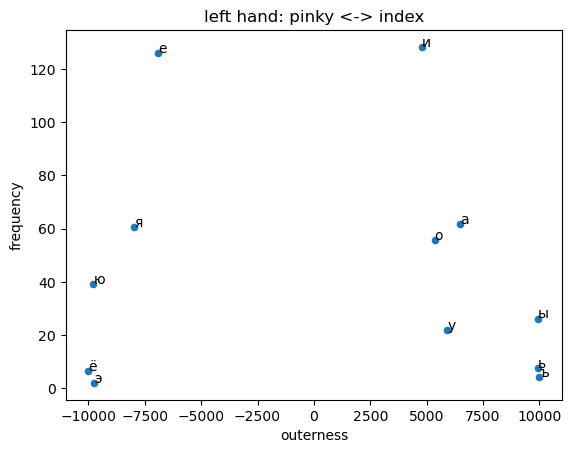

In [6]:
CORP.display_outerness("t1 == 'v' & t2 == 'v'", True)

## Consonants

In my layout, С (s) is the outermost (but in home column), Р (r) and Н (n) are innermost (in home column). Т comes too often before Р (-tr- is frequent like in English), so it isn't on the index finger.

freq_out     freq_in       outer   frequency    outerness
l1                                                             
щ     0.332079    7.305740   -6.973661    7.637819 -9130.434783
ц     1.251683    8.480789   -7.229106    9.732472 -7427.821522
л    16.910489   85.957397  -69.046907  102.867886 -6712.192699
р    62.430870  182.285879 -119.855009  244.716749 -4897.703549
н    76.659182  158.146283  -81.487101  234.805466 -3470.409051
т   120.391445  216.490026  -96.098582  336.881471 -2852.593267
ф     3.933860    5.236632   -1.302772    9.170492 -1420.612813
к    55.099585   70.400768  -15.301183  125.500354 -1219.214329
м    24.062962   28.533258   -4.470296   52.596220  -849.927149
ш     9.451482    8.940591    0.510891   18.392073   277.777778
в    65.675027   56.785525    8.889502  122.460553   725.907384
х     8.812868    6.743760    2.069108   15.556628  1330.049261
д    54.358794   40.513650   13.845144   94.872443  1459.343026
г    26.694050   10.958610   15.735440   37.652661  4179.104478
ж    25.851080   10.243363   15.607718   36.094443  4324.133050
с   254.117142   94.029473  160.087669  348.146615  4598.283073
п    89.737990   25.442368   64.295622  115.180357  5582.168995
ч    39.032066    8.761779   30.270287   47.793845  6333.511491
б    34.996028    7.075839   27.920189   42.071867  6636.308440
з    47.308499    4.036038   43.272461   51.344537  8427.860697
й    19.286132    0.025545   19.260588   19.311677  9973.544974

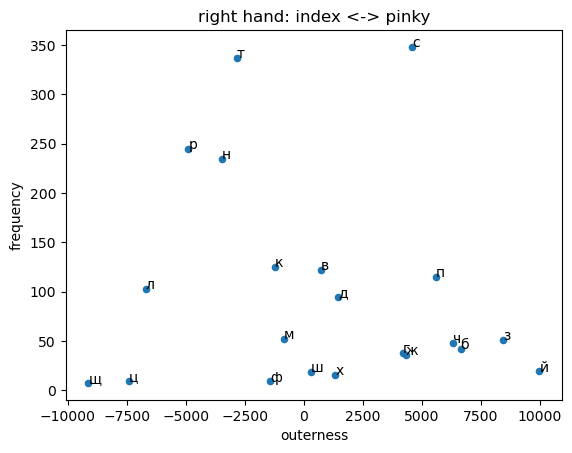

In [7]:
CORP.display_outerness("t1 == 'c' & t2 == 'c'")

Outputting the bigrams to Excel file, to see stats for each letter -- what letters come before it, and what ones come after.

In [8]:
BG = CORP.bigrams
dg2 = BG[BG.l1.isin(BASE_KEYS) & BG.l2.isin(BASE_KEYS)].copy()
dg2['kind_after'] = dg2.t2
dg2['dir'] = 'before'
dg2['kind_before'] = dg2.t1
dg2['letter_before'] = dg2.t1.isin(['v', 'c'])
dg2['letter_after'] = dg2.t2.isin(['v', 'c'])
pd1 = dg2.rename(columns={'l1': 'prev', 'l2': 'letter'}).pivot_table('num', 'letter', ['dir', 'kind_before', 'prev'], fill_value=0)
dg2['dir'] = 'after'
pd2 = dg2.rename(columns={'l2': 'next', 'l1': 'letter'}).pivot_table('num', 'letter', ['dir', 'kind_after', 'next'], fill_value=0)
dg3 = pd1.join(pd2)
dg3

dg3.melt(ignore_index=False).rename(
    columns={'variable_0': 'dir', 'variable_1': 'kind', 'variable_2': 'other', 'value': 'num'}
).reset_index().to_csv('all-letters-melt.csv')

# The Code with The Scoring Rules <a name="scoring-code">

Here we define what fingers press what keys. 0 = left pinky, 9 = right pinky, others in between as you may imagine, left to right.

Spaces & line breaks in beginning of FINGERS/POS_PENALTY are insignificant, but spaces in actual lines with numbers are. These positions must be matched by keyboard descriptions. 

In [9]:
d = {'a': {'id': 1, 'val': 2}, 'b': {'id': 3, 'val': 4}}
pd.DataFrame.from_dict(d, orient='index')

id  val
a   1    2
b   3    4

In [10]:
STANDARD_FINGERS = '''
001233 6678999
001233 66789999
 01233 6678999
 01233 66789
4
''' 

STANDARD_PENALTIES = '''
753246 6422246
321134 43112357
 00002 2000023
 11114 41111
0
'''

# min(standard, 1) for non-home row
# STANDARD_PENALTIES = """
# 642246 6422246
# 422224 42002246
#  00002 2000024
#  22224 42222
# 0
# """

# standard + 2 everywhere in non-home pos
# STANDARD_PENALTIES = """
# 864468 8644468
# 644446 64224468
#  00004 4000046
#  22226 62224
# 0
# """

In [11]:
def parse_layer(text):
    "Parses text of a layer of layout, fingers or position penalties."
    keys_map = {}
    for ir, row in enumerate(text.lstrip().rstrip().split('\n')):
        for ic, f in enumerate(row):
            if f != ' ' and f != '∅':
                keys_map[(ir, ic)] = f
    return keys_map


def get_finger_props(finger):
    return {
        'finger': finger,  # finger unique ID. (left pinky = 0, left ring = 1, ... right pinky = 9)
        'ftype': floor(abs(4.5 - finger)),  # number in its hand (thumb = 0, pinky = 4)
        'hand': (0 if finger < 4.5 else 1), # hand numebre. Left = 0, right = 1
        'penalty': 0, # position penalty (ie. monogram). From POS_PENALTY
    }

    
KEYCAP_LAYER_SHIFTS = {
    0: (0, 0),
    1: (-.2, .2),
    2: (.2, -.2),
    3: (.5, .6),
    -1: (0, 0)
}


def lighten_color(color, amount=0.5):
    c = colorsys.rgb_to_hls(*matplotlib.colors.to_rgb(color))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


def color_scale(val, min_val, max_val, scale=plt.cm.plasma, lighten=.5):
    return lighten_color(scale((val - min_val) / (max_val - min_val)), lighten)


class Keyboard:
    """Keeps fingers and penalties map of a model or a fingers positioning scheme."""
    def __init__(self, name, fingers, penalties, key_shape=None, extra_keys=None):
        """Creates the instance. Fingers and penalties are strings with lines as rows,
        and line positions of chars as columns. They must match exactly.
        
        Parameters
        ----------
        - name, str: just the name
        - fingers, str: string, where line is row, char pos is column, and the number in there (0..9)
            is the finger. 0 = left pinky, 1 = left ring, .. 9 = right pinky.
            Penalties map and layouts must reproduce these positions.
        - penalties, str: integer penalties in the same positions.
        - key_display, function: a callback that processes a key to be rendered.
            Like adding stagger, depending on row/column.
            Input params: (x: float, y: float, width: float, height: float, keycap: list[str])
            Output: a tuple with the same items.
            This callback won't process `extra_keys`.
        - extra_keys, list: a list of tuples of extra keys to render in the image:
            (x: float, y: float, width: float, height: float, keycap: str).
            Keycap is a single string.

        """
        self.name = name
        self.extra_keys = extra_keys or []
        self.key_shape = key_shape
        self.keymap = {}
        for (ir, ic), f in parse_layer(fingers).items():
            props = get_finger_props(int(f))
            self.keymap[(ir, ic)] = props

        for (ir, ic), p in parse_layer(penalties).items():
            if (ir, ic) not in self.keymap:
                raise ValueError("Penalties map doesn't match fingers map!")
            
            self.keymap[(ir, ic)]['penalty'] = int(p)
    
    def key_coords(self):
        """Generates coords data to display the keyboard. 1 unit = 2 cm, step of standard keyboard. Returns:
        `(all_coords, width, height)`, where
        
        * all_coords: a list of tuples for each key: (row, column, x, y, width, height)
        * width: width of the entire keyboard
        * height: height of the entire keyboard
        """
        all_keys = []
        for (ir, ic), k in self.keymap.items():
            if self.key_shape:
                x, y, w, h = self.key_shape(ic, ir, 1, 1)
            else:
                x, y, w, h = ic, ir, 1, 1
            
            all_keys.append((ir, ic, x, y, w, h, None))
        
        width = max(i[2] + i[4] for i in all_keys) - min(i[2] for i in all_keys)         
        height = max(i[3] + i[5] for i in all_keys) - min(i[3] for i in all_keys) 
        return all_keys, width, height
        
        
    def raw_display(self, key_caps=None, colors=None, title=None):
        all_keys, width, height = self.key_coords()
        for (x, y, w, h, cap) in self.extra_keys:
            all_keys.append((None, None, x, y, w, h, cap))
        
        fig, ax = plt.subplots(1, 1, figsize=(width, height))
        ax.set_axis_off()
        ax.set_title(title)
        
        font = {'family': 'dejavu sans',
            'color':  '#000',
            'size': 14,
            'linespacing': 1.7,
            'ha': 'center'
        }
        
        max_x = max_y = min_x = min_y = 0
        
        for ir, ic, x, y, w, h, cap in all_keys:
            if cap:
                caps = [cap]
            elif key_caps:
                caps = key_caps.get((ir, ic), [])
            else:
                caps = []
            key_color = colors.get((ir, ic), '#ccc')
                
            y *= -1
            min_x = min(x, min_x)
            min_y = min(y, min_y)
            max_x = max(x + w, max_x)
            max_y = max(y + h, max_y)        

            # we draw the rectangle making a outer margin of 0.2.
            # We just shift the box right-bottom, and make it narrower and lower by 0.4,
            # so that all keys are still referred by key size (1 unit = 20mm),
            # and this is done consistently everywhere.
            ax.add_patch(Rectangle((x + .2, y + .2 - h + 1), w - .4, h - .4,
               color=key_color, ec=key_color, 
               capstyle='round', linewidth=15, linestyle='-', joinstyle='round'))
            
            if key_caps is None:
                continue
            
            if not isinstance(caps, (list, tuple)):
                caps = (caps,)
                
            for layer, cap in enumerate(caps):
                if cap in ('⌴', ' '): continue
                if layer not in KEYCAP_LAYER_SHIFTS:
                    raise ValueError(f'too many layers in key caps: {caps} in keymap')

                dx, dy = KEYCAP_LAYER_SHIFTS[layer]
                
                # same shifting for text
                text_y = y + dy * h + - h / 2 + 1 - .1
                text_x = x + dx * w + w / 2
                
                font_size = 14 if layer == 0 else 10
                plt.text(text_x, text_y, cap, fontdict={
                    **font, 'color':  '#000', 'size': font_size}) # if key.get('c', 0) else '#444444'})
        
        ax.set_xlim(min_x - .25, max_x + .25)
        ax.set_ylim(min_y - .25, max_y + .25)
        return ax
        
    def display(self):
        """
        Displays the keyboard. Empty or with `key_caps` from a layout.
        
        """
        max_pen = max(k['penalty'] for k in self.keymap.values())
        
        return self.raw_display(
            key_caps={coord: [k['penalty']] for coord, k in self.keymap.items()},
            colors={coord: color_scale(k['penalty'], 0, max_pen) for coord, k in self.keymap.items()},
            title = f'{self.name} with monogram penalties'
        )
        

<AxesSubplot: title={'center': 'Standard staggered keyboard with monogram penalties'}>

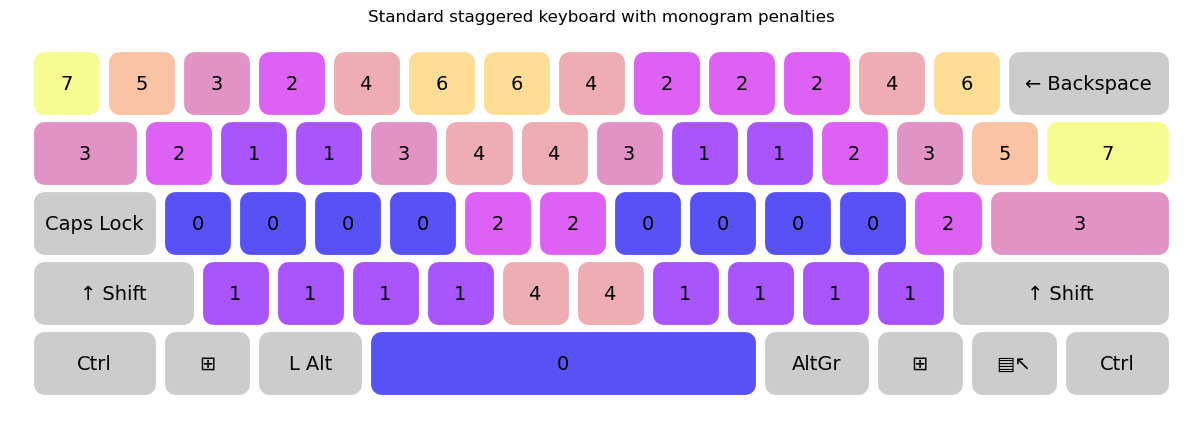

In [12]:
ROW_STAGGER = { 0: 0, 1: .5, 2: .75, 3: 1.25, 4: 1.75 }
                
def std_key_shape(x, y, w, h):
    if x > 6:
        x -= 1


    if x == 0 and y == 1: # '→':
        x -= .5
        w = 1.5
    
    if y == 4: # space bar
        w = 5.25
        x = 2.75
        
    if y == 1 and x == 13: # the / key above the enter
        w = 1.75
    
    if y == 2 and x == 12: # enter
        w = 2.5
        
    if y not in ROW_STAGGER: 
        raise ValueError(f"Row must be 0..=4, got {y} instead.")

    x += ROW_STAGGER[y]

    return x, y, w, h
        
STD_EXTRA_KEYS = [
    (13, 0, 2.25, 1, '← Backspace'),
    
    (0, 2, 1.75, 1, 'Caps Lock'),
    
    (0, 3, 2.25, 1, '↑ Shift'),
    (12.25, 3, 3, 1, '↑ Shift'),

    (0, 4, 1.75, 1, 'Ctrl'),
    (1.75, 4, 1.25, 1, '⊞'),
    (3, 4, 1.5, 1, 'L Alt'),
    (9.75, 4, 1.5, 1, 'AltGr'),
    (11.25, 4, 1.25, 1, '⊞'),
    (12.5, 4, 1.25, 1, '▤↖'),
    (13.75, 4, 1.5, 1, 'Ctrl'),
]
STANDARD_KBD = Keyboard('Standard staggered keyboard', STANDARD_FINGERS, STANDARD_PENALTIES, std_key_shape, STD_EXTRA_KEYS)

STANDARD_KBD.display()

<AxesSubplot: title={'center': 'ergodox with monogram penalties'}>

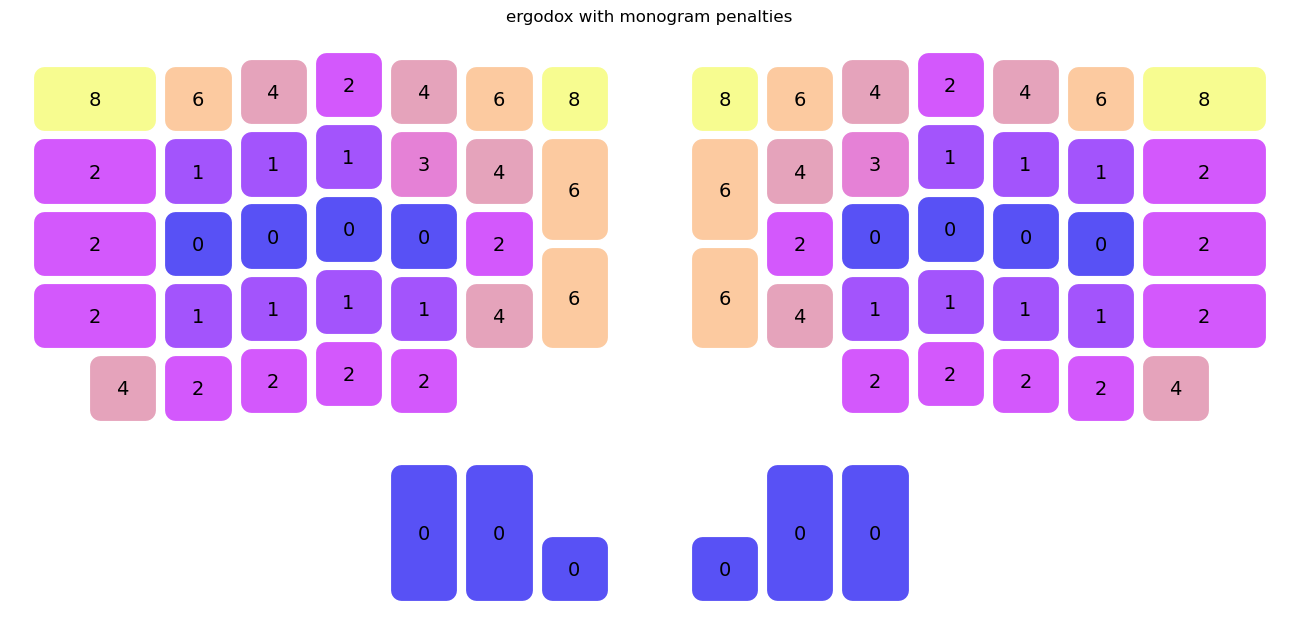

In [13]:
ERGODOX_VSTAG = {2: .1, 3: .2, 4: .1, 10: .1, 11: .2, 12: .1} # x => delta y
def ergodox_key_shape(x, y, w, h):
    if x == 0 and y <= 3:
        w = 1.75
        x -= .75
    
    if x == 14 and y <= 3:
        w = 1.75

    if x in (6, 8) and y in (1, 3):
        h = 1.5
        if y == 3:
            y -= .5

    # thumb blocks
    if y == 5:
        y += .5
        if x in (6, 8):
            y += 1
        else:
            h += 1
    
    # vertical stagger
    if y <= 4:
        y -= ERGODOX_VSTAG.get(x, 0)
    return x, y, w, h
                
        
        
ERGODOX = Keyboard('ergodox',

# note: in the middle columns, there are 2 tall keys, not 3, but I'm not sure how to represent it here,
# so for now, it's set like there are 3.
'''
0012333 6667899
0012333 6667899
001233   667899
0012333 6667899
00123     67899
    444 555
''', # ehm... in reality, I press the outermost keys on the top row with the ring fingers, not pinky, so...
# maybe it's better to write the real usage here...

'''
8642468 8642468
2111346 6431112
200002   200002
2111146 6411112
42222     22224
    000 000
''', ergodox_key_shape)

ERGODOX.display()

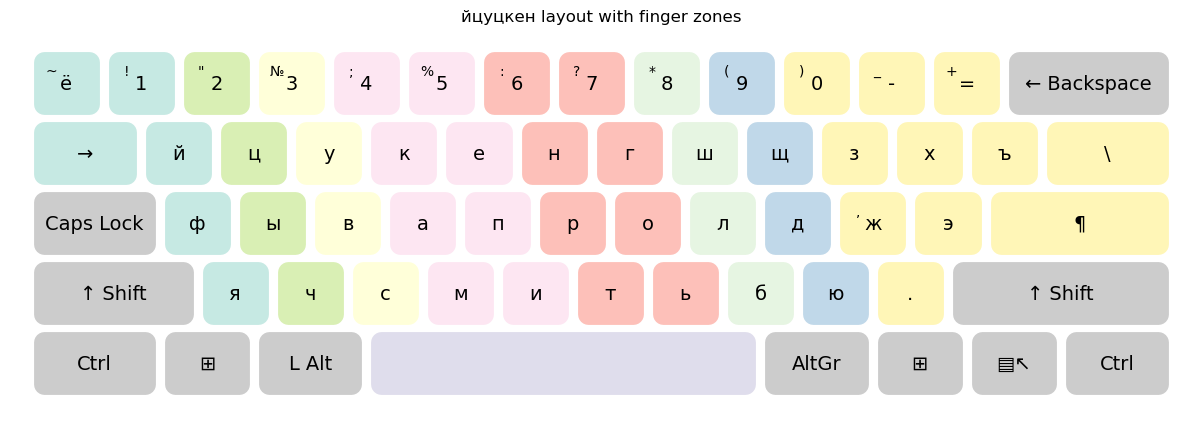

In [53]:
class Layout:
    """Keeps positions of keys on a particular keyboard."""
    def __init__(self, name, layout_config, debug=False):
        """Initialize the layout. `layout_config` must be either text, or 2-tuple (layout text, Keyboard instance)."""

        if isinstance(layout_config, tuple):
            if len(layout_config) != 2:
                raise ValueError(f'Layout must be either a string, or a 2-tuple (layout, keyboard). Got tuple of {len(layout_config)} instead.')
            layout_text, keyboard = layout_config
        else:
            layout_text, keyboard = (layout_config, STANDARD_KBD)

        layers = layout_text.lstrip().rstrip().split('\n\n')
        maps = [parse_layer(l) for l in layers]
        if debug: print('layout', layers)
        keys = ''.join(k for m in maps for k in m.values())
        if debug: print('layout', keys)
        key_counts = defaultdict(int)
        for k in keys:
            key_counts[k] += 1

        for k in set(keys):
            if key_counts[k] > 1 and k not in ('⌴', '¶', '→'):
                print(f'key "{k}" repeated: {key_counts[k]}')

        missing = BASE_KEYS - set(keys)

        if missing:
            raise ValueError(f"Missing keys: {''.join(missing)}, present keys: {''.join(keys)}")

        # making a dict: {letter: (layer, row, column, <finger id>, <finger num in hand>, hand, <pos penalty>)}
        # the last 4 items come from get_finger_props(...) calls
        # make any changes here => change the pd.DataFrame call below
        data = {}
        
        for il, layer in enumerate(maps):
            for (ir, ic), k in layer.items():
                if debug: print(il, ir, ic, k, (ir, ic) in keyboard.keymap)
                if k != '∅' and (ir, ic) in keyboard.keymap:
                    data[k] = {'layer': il, 'row': ir, 'column': ic,
                               'key_count': key_counts[k],
                               **keyboard.keymap[(ir, ic)]}

        self.name = name
        self.keymap = pd.DataFrame.from_dict(data, orient='index')
        self.keyboard = keyboard
        self.original_text = layout_text


    def get_monogram_cost(self, l2):
        """Simply looks up keymap and gets pos_penalty field. Lowercases the letters."""
        
        if l2 not in self.keymap.index:
            if l2.lower() in self.keymap.index:
                l2 = l2.lower() # here we should but don't penalize Shift/AltGr pressing
            else:
                if l2 in BASE_KEYS or l2.lower() in BASE_KEYS:
                    print(l2)
                    print(self.keymap.index)
                    raise ValueError(f'base key \'{l2}\' is not in the layout! (may be caused by unquoted backslash)')
                return 0

        return self.keymap.loc[l2].penalty


    # THE MAIN PENALTIES RULES
    # Here we assign costs and also put a text name for the reason why bigram got it,
    # to quickly see WTF is happening
    def get_bigram_cost(self, bigram):
        l1, l2 = bigram

        if l2 not in self.keymap.index:
            if l2.lower() in self.keymap.index:
                l2 = l2.lower() # lowercase (= no penalties for shifts)
            else:
                return 0, 'L2 not in kbd'
        k2 = self.keymap.loc[l2]

        if l1 not in self.keymap.index:
            if l1.lower() in self.keymap.index:
                l1 = l1.lower() # lowercase of l1.
            else:
                return 0, 'L1 not in kbd'
        k1 = self.keymap.loc[l1]

        rules = (
            (k1.ftype == 0 or k2.ftype == 0, 0, 'space bar'),
            (k1.hand != k2.hand, 0, 'altern hands'),
            (l1 == l2, 0, 'same key'),

            (abs(k2.row - k1.row) >= 2 and k1.ftype == k2.ftype, 8, 'same finger over row'),
            (k1.ftype == k2.ftype, 6, 'same finger adj row'),

            (k1.ftype == 1 and k2.ftype == 4, 2, 'index -> pinky'),
            ((k1.ftype, k2.ftype) in ((4, 3), (3, 4)) and abs(k1.row - k2.row) == 1, 4, 'ring <-> pinky'),

            (abs(k1.ftype - k2.ftype) == 1 and abs(k2.row - k1.row) > 1, 10, 'adj finger over row'),
            (abs(k1.ftype - k2.ftype) == 2 and abs(k2.row - k1.row) > 1, 8, 'over 1 finger, over 1 row'),
            (k1.ftype == 4 and k2.ftype == 1 and abs(k2.row - k1.row) > 1, 4, 'pinky -> index over 1 row'),
            (k1.ftype == 1 and k2.ftype == 4 and abs(k2.row - k1.row) > 1, 6, 'over 2 fingers, over 1 row'),
            
            (k1.ftype > k2.ftype + 1 and k2.row == k1.row, 0, 'in, over 1 finger, same row'),
            (k1.ftype > k2.ftype + 1 and abs(k2.row - k1.row) == 1, 1, 'in, over 1 finger, adj row'),
            (k1.ftype == k2.ftype + 1 and k2.row <= k1.row, 2, 'in, adj finger, same or adj row'),
            (k1.ftype > k2.ftype and k2.row > k1.row, 1, 'in, lower row'),
            
            (k1.ftype == 1 and k2.ftype == 2 and k1.row == k2.row, 1, 'index->middle same row'),
            (k2.ftype > k1.ftype, 4, 'out, over one finger'),
            (k1.ftype + 1 == k2.ftype and k1.row == k2.row, 3, 'out, next finger'),
            (k1.ftype + 1 == k2.ftype and abs(k1.row - k2.row) >= 1, 5, 'out, next finger'),
        )

        for cond, penalty, reason in rules:
            if cond:
                return penalty, reason

        return 4, 'none'

    def keycaps(self):
        keycaps = defaultdict(list)
        for k, r in self.keymap.sort_values('layer').iterrows():
            keycaps[(r['row'], r['column'])].append(k)
        return keycaps

    def display(self):
        """
        Shows the layout with the keyboard.
        """
        
        colors = self.keymap.groupby(['row', 'column']).agg({'finger': 'first'})['finger'].apply(lambda f:
                 lighten_color(plt.cm.Set3((f + (f % 2) * 10) / 20), .5)).to_dict()
        self.keyboard.raw_display(self.keycaps(), colors, f"{self.name} layout with finger zones")

l = Layout('йцуцкен', r'''
    
ё12345 67890-=
→йцуке нгшщзхъ\
 фывап ролджэ¶
 ячсми тьбю.
⌴

~!"№;% :?*()_+
 ∅∅∅∅∅ ∅∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅,
''')
l.display()

# How Standard Keyboard is Really Used

In [54]:
real_kbd = Keyboard('real fingers', ''' 
000012 3678999
000123 66789999
 01233 6678999
 01233 667899
4
''', '''
864222 4222468
622123 43112246
 00002 2000024
 11114 411112
0
''',
std_key_shape, STD_EXTRA_KEYS)

# Layouts <a name="layouts">

## Rules:

1. Spaces/linebreaks ARE SIGNIFICANT! (Except at the beginning and end of the whole string -- those are stripped.)
2. Two linebreaks = new level (Shift, AltGr), except for start and end of the whole string.
3. Rows must be in the same order.
4. Letters positions must match those in `FINGERS` and `POS_PENALTY` strings of th keyboard (`STANDARD_KBD` by default).
5. Backslash (`\`) requires Python's raw string syntax: `r''`. Otherwise, duplicate it -- but it creates a lot of confusion with positions.
6. `∅` means no letter at all (or same letter as in lower level). Currently, we don't compute penalties for Shift/AltGr.
7. `¶` means Enter key, and every linebreak in text is treated as hitting this key.
8. `⌴` means space. This is irrelevant for skewed keyboards (they get 0 for any digrams with space), but will be needed for Ergodox.
9. `→` means Tab. Tabs in the text are also scored as keypresses (although in literature corpus they're absent, but if we inserted any text with tables, we'd be able to account for the tab key).
    
## How to test Ergodox and other non-standard models
    
By default, these layouts are used with standard staggered keyboard. If you want Ergodox, then instead of 1 string provide a 2-tuple:
    
```python
    'my_layout': (r'''<the layout>''', ERGODOX),
```
    
If you want different key positions, make a different `Keyboard` instance:
    
```python
    'my_layout': (r'''<the layout>''', Keyboard(<fingers>, <penalties>)),
```
    
search for `леонов` (new finger positions in standard kbd) and `optozorax` (Ergodox) in the dictionary below for examples.

In [55]:
LEONOV_KBD = Keyboard("leonov's remapping", '''
0001233 667899
0001233 667899
 001233 667899
 001233 6678
4
''',

'''
8642226 622246
6421134 431124
 400002 200002
 211114 4111
0
''',
# '''
# 3211113 311123
# 2111112 211112
#  200001 100001
#  111112 2111
# 0
# ''',
#  '''
# 4322224 422234
# 3211123 321123
#  200002 200002
#  211113 3111
# 0
# ''',
         std_key_shape, STD_EXTRA_KEYS
)

In [56]:
layouts = {
    # standard Russian layout ~1890
    'йцукен': r'''
    
ё12345 67890-=
→йцуке нгшщзхъ\
 фывап ролджэ¶
 ячсми тьбю.
⌴

~!"№;% :?*()_+
 ∅∅∅∅∅ ∅∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅,
''',

    # QWERTY transliterated ~1970
    'usphonetic': r'''
    
ю12345 67890-ь
→яверт ыуиопшщэ
 асдфг чйкл;'¶
 зхцжб нм,.%
⌴

∅!"ёЁъ Ъ?*()_∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅:"∅
 ∅∅∅∅∅ ∅∅<>?
''',

    # Dvorak transliterated ~2000
    'rusdvorak': r'''
    
ю12345 67890шщ
→',.пы фгцрл/чэ
 аоеуи дхтнс-¶
 ;яйкь бмвжз
⌴

∅!@ё∅ъ %&*()_∅
∅∅∅∅∅∅ ∅∅∅∅∅∅?∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 >:∅∅∅ ∅∅∅∅∅
''',

    # "Dictor" layout 200?
    'диктор': r'''
    
ё12345 67890-=
→цья,. звкдчшщъ
 уиеоа лнтсрй¶
 фэхыю бмпгж
⌴

∅!"№;% ;\?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 >:∅∅∅ ∅∅∅∅∅
''',

    # Zubachov's layout 2007
    'зубачёв': r'''
    
ё12345 67890-=
→фыаяъ ймрпхцщ
 гиеоу лтснзж¶
 шью.э бдвкч
⌴

∅!"№;% :\?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅,∅ ∅∅∅∅∅
''',

    # Skoropis 2014 (literally "Fastwrite") from https://cont.ws/@russkivek/93620
    'скоропис': r'''
    
*.ёъ?! ∅-\'()∅
→цья,. звкдчшщ"
 уиеоа лнтсрй¶
 фэхыю бмпгж
⌴

%12345 67890∅∅
∅∅∅∅;: ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
''',

    # ANT layout 200?
    # this layout put Ъ's upper and lower case in different places,
    # which my code doesn't understand.
    # had to put the letter on one key to process
    'ант': r'''
    
\!?'"= +-*/%()
→гпрдм ыияухцжч
 внстл ьоеакз¶
 щйшб, .юэёф
⌴

_97531 02468""
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅; :∅∅∅∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ъ∅∅∅∅∅∅
 ∅∅∅∅; :∅∅∅∅
''',
    
    # UNGVS 2019 https://ubuntu-mate.community/t/make-your-own-custom-keyboard-layout-for-linux/19733/
    'ugnvs': r'''
    
`12345 67890-=
→пдмкз буяьыг:'
 аиеол внтср,¶
 щцэюф хчжйш
⌴

~!?/$% <>*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅;"
 ∅∅∅∅∅ ∅∅∅∅∅.∅
 ∅∅∅∅∅ ∅∅∅∅


∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅ъ∅∅∅∅
 ∅∅ё∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
''',
    
    # Leonov 2023 https://habr.com/ru/articles/717912/
    # author uses chords for comma and period, here instead they're put in 3rd layer on index fingers.
'леонов': # 
('''
∅123456 7890-=
→щцклбй ъыяэфш
 чзвнтд иаоес¶
 жхпрмг ёьую
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅
 ∅∅∅∅.∅ ∅,∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''',
LEONOV_KBD),
'леонов2': # 
('''
∅123456 7890-=
→чгкблщ ёэыяфш
 цснтрд йиаое¶
 жзпмвх ъюуь
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅,∅ ∅.∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''', LEONOV_KBD),
'леонов3': # 
('''
ъ123456 7890-=
→щчклбй ёыяэфш
 цсвнтд иаоеп¶
 жзхрмг ьую,
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅.
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''', LEONOV_KBD),
    'optozorax': # 2021 https://optozorax.github.io/p/my-keyboard-layout/#russkii-iazyk
    # author never mentions parens in his keyboard definition. I just tossed them wherever there was place.
    ('''
    
+;.:=@∅ ∅*!?#/∅
-йцуеф∅ ∅щгтнз∅
"кмвап   ролджэ
'ячсиы∅ ,шьбюхё
∅∅∅∅∅∅∅ ∅∅∅\∅∅∅
    ∅∅¶ .⌴∅

(75319^ №02468)
_∅∅∅∅∅∅ $∅∅∅∅∅∅
&∅∅∅∅∅   ∅∅∅∅∅∅
|∅∅∅∅∅∅ ∅∅ъ∅∅∅∅
∅∅∅∅∅     ∅%∅∅∅
    ∅∅∅ ∅∅∅
''',
ERGODOX),
    
    'ergodox':  # standard Russian on Ergodox (has troubles with right end of the upper row)
(''' 
ё123456 7890\ъ∅
-йцуке∅ ∅нгшщзх
=фывап   ролджэ
∅ячсми∅ ∅тьбю.∅
∅∅∅∅∅     ∅∅∅∅∅
    ⌴→∅ ∅¶∅

∅!"№;%: ?*()/∅∅
_∅∅∅∅∅∅ ∅∅∅∅∅∅∅
+∅∅∅∅∅   ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅,∅
∅∅∅∅∅     ∅∅∅∅∅
    ∅∅∅ ∅∅∅

''',
ERGODOX),
    
    # my layouts 2021
    'тест1': r'''
    
ё12345 67890-=
→йцуке нгшщзхъ\
 фыоап рвлджэ¶
 ячсми тьбю.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест2': r'''
    
ё12345 67890-=
→йцуюк енгбзхъ\
 ыоаия втсрпч¶
 элмдь жшщф.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест3': r'''

ё12345 67890-=
→ъцуюя ьнгбчхй\
 ыоаие втсрпз¶
 эфкмд жшщл.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест4': r'''
    
ё12345 67890-=
→ъэуюя цлнгчхй\
 оаыеи втсрпз¶
 фдьмк жшщб.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест5': r'''
    
ё12345 67890-=
→ъуьюя йлнгчцх\
 оаыеи втсрпз¶
 .фжэд мкшщб
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест6': r'''
    
/12345 67890-=
→ёъьую янвгчйцх
 оиаые лрптсз¶
 ,эфшщ кбмдж
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
   
    'тест7': r'''
    
/12345 67890-=
→ёъьую янджчйцх
 оиаые лрптсз¶
 ,эфшщ вбмкг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',

    'тест8': r'''
    
/12345 67890-=
→ёъыью янжкчзгх
 аоиуе лртпсд¶
 цэфшщ вмбй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    # 2021, the first tested on a real keyboard
  'тест9': r'''
    
/12345 67890-=
→ёъыью янжкчзгх
 аоиуе лртпсд¶
 цэфщш вмбй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    # my layouts below: 2024. #10 is the first after manual test
  'тест10': r'''
    
/12345 67890-=
→ёоюэф йнзкдчжц
 ауиея лртпбс¶
 ъыьшщ вмхг,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
  'тест11': r'''
    
/12345 67890-=
→ёоюяф лндкзчжц
 ауиеэ вртпбс¶
 ъыьшщ мхгй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
''',
  'тест12': r'''
    
/12345 67890-=
→ёуюяф лндкзчжц
 аоиеэ вртпбс¶
 ъыьшщ мхгй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест13': r'''
    
/12345 67890-=
→ёуюяф лндкзчжц
 аоиеэ вртпбс¶
 щыъьй мхгш,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест14': r'''
    
/12345 67890-=
→ёуюяф лндпзчжц
 аоиеэ вртксб¶
 щыъьй мхгш,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',

    'тест15': r'''
    
/12345 67890-=
→ёуюяф шндпзчжц
 аоиеэ вртксб¶
 щыъьй млхг,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест16': r'''    
/12345 67890-=
→ёуюяф шндгзчжц
 аоиеэ вртксб¶
 щыъьй млхп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    
'тест17': r'''    
/12345 67890-=
→ёуюяф шндмзчжц
 аоиеэ вртксб¶
 щыъьй хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест18': r'''    
/12345 67890-=
→ьуюяй шндмзчжц
 аоиеэ вртксб¶
 щыъёф хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест19': r'''    
/12345 67890-=
→ьуюяэ шндмвчжц
 аоией зртксб¶
 щыъёф хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест20': r'''    
/12345 67890-=
→ьуюяэ шнмдвчжц
 аоией гртксз¶
 щыъёф хлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест21': r'''    
/12345 67890-=
→ъыфхэ шнмдвчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест22': r'''    
/12345 67890-=
→ъыфхэ шнмдвчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест23': r'''    
/12345 67890-=
→ъыфхэ шнмвдчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест24': r'''    
/12345 67890-=
→ъыфхэ шнмвдзжц
 аоией гртксб¶
 ьуюяё щ.лпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅,∅∅∅
∅
''', 
'тест25': r'''    
/12345 67890-=
→ъыфхэ шнмвдзжц
 аоией гртксч¶
 ьуюяё щлпб.
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',
    # alien layout experiment #1, with rare letters Ё Щ Ъ on AltGr
    'ино1': r'''    
/12345 67890+
→:ыфхэ цнмвчзж
 аоией ,ртксд¶
 ьуюя- шлбпг
⌴

\!"№∅% ∅?*_()
∅;∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅= ∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅ё∅ ∅∅∅∅∅∅∅
 ъ∅∅∅∅ щ∅∅∅∅
∅
''',

    'тест26': r'''

ъ12345 67890-=
→щфыхё цнмвчзж/
 аоией ,ртксд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    'тест27': r'''

ъ12345 67890-=
→эыфх: цнмвчзжш
 аоией ,ртксд¶
 ьуюяё щлбпг
⌴

\!"№∅% ∅?*()_+
∅∅∅∅∅; ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
    # Alien layout #2, with voiced consonants on AltGr over their voiceless counterparts.
    # e.g. in English B<->P, T (mat) <-> D (mad), K (keel) <-> G (good), V <-> F,
    # Russian has more pairs.
    # same for vowels: compound vowels Я Ю Ё and rare Ё Э are on AltGr,
    # Ы is separated twin of И and also is put there
    
    # This scores great, but abuses the scoring system, because Shift & AltGr aren't penalized
    # In reality, it's hard to hit and release AltGr quickly
    'ино2': r'''

 12345 67890
→-()х: цнмфш+=
 аоией ,ртксч¶
 ьу я! щл п? 
⌴

\∅"№∅% ∅∅*∅∅∅∅
∅∅∅∅∅; ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅вж∅∅
 ∅ёыэ∅ ∅∅дгз∅∅
 ъю∅∅∅ ∅∅∅б∅
∅
''',
'тест28': r'''

ъ12345 67890-=
→щфыхё цмнвчзж/
 аоией ,ртксд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

    'тест29': r'''

ъ12345 67890-=
→щфыхё цмнкчзж/
 аоией ,ртвсд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
  'ино3': r'''

 12345 67890
→-()х: +кмфшщ=
 аоией ,ртнсч¶
 ьу  !  лп ? 
⌴

\∅"№∅% ∅∅*∅∅∅∅
∅∅∅∅∅; ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅г∅вж∅∅
 яёыэ∅ ∅д∅зц∅
 ъю∅∅∅ ∅∅∅б∅
∅
''',
    
'тест30': r'''

ъ12345 67890-=
→щфыхэ жвмкзгш/
 аоией ,ртнсд¶
 ьуюяё цлбпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест31': r'''

ъ12345 67890-=
→щфыхэ жмвкзгш/
 аоией ,ртнсд¶
 ьуюяё цлбпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест32': r'''

ъ12345 67890-=
→ьыхяё жшвкчзщ/
 аоией ,ртнсд¶
 пуфюэ цлмбг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест33': r'''

ъ12345 67890-=
→щфыхэ жмвкзчш/
 аоией ,ртнсд¶
 ьуюяё цлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
'тест33эрго': 
(r''' 
ъ123456 7890-=/
шщфыхэ∅ ∅жмвкзч
=аоией   ,ртнсд
∅ьуюяё∅ ∅цлбпг∅
∅∅∅∅∅     ∅∅∅∅∅
    ⌴→∅ ∅¶∅

∅!"№;%: ?*()/∅∅
_∅∅∅∅∅∅ ∅∅∅∅∅∅∅
+∅∅∅∅∅   .∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅     ∅∅∅∅∅
    ∅∅∅ ∅∅∅

''',
ERGODOX),


}

    

In [57]:
class Result:
    # Gets the cost for input KBD text, bigrams & fingers maps
    def __init__(self, corpus, layout):
        bigram_df = corpus.bigrams.copy()

        # taking the text of keyboard layout and encode it into keymap a dataframe
        bigram_df['price_l2'] = bigram_df.l2.apply(layout.get_monogram_cost) 

        # calculate bigrams cost
        bigram_df[['price_di', 'category']] = bigram_df.bigram.apply(lambda d: pd.Series(layout.get_bigram_cost(d)))
        bigram_df['price'] = bigram_df.price_l2 + bigram_df.price_di
        bigram_df['cost'] = bigram_df.price * bigram_df.num
        bigram_df['finger'] = bigram_df['l2'].map(layout.keymap.finger)
        bigram_df['column'] = bigram_df['l2'].map(layout.keymap.column)
        bigram_df['row'] = bigram_df['l2'].map(layout.keymap.row)
        self.bigrams = bigram_df
        self.corpus = corpus # it's not copied here, just a pointer
        self.layout = layout # also not copied
        self.score = bigram_df.cost.sum() / bigram_df.num.sum()

    def compare(self, other):
        x = self.bigrams[['bigram', 'num', 'category', 'price', 'cost']].merge(
            other.bigrams[['bigram', 'category', 'price', 'cost']],
            on='bigram', suffixes=['_old', '_new'])
        x['delta'] = x['cost_new'] - x['cost_old']
        return x[x.delta != 0].sort_values('delta', ascending=False)

    def display(self, *items):
        for what in items:
            show_layout = what == 'layout'
            show_costs = what in ('cost', 'costs')
            show_nums = what in ('freq', 'frequencies', 'num', 'nums')
            show_arrows = what in ('arrow', 'arrows')

            if show_layout:
                self.layout.display()
            elif show_costs:
                df = self.bigrams.groupby(['row', 'column']).agg({'cost': 'sum', 'num': 'sum'})
                df['meancost'] = df['cost'] / df['num']

                min_cost = df['meancost'].min()
                max_cost = df['meancost'].max()

                colors = df['meancost'].apply(color_scale, args=(min_cost, max_cost)).to_dict()
                self.layout.keyboard.raw_display(
                    df['meancost'].round(2).to_dict(), colors, f'{self.layout.name} costs (on 2nd keys of bigrams)')

            elif show_nums:
                total = self.bigrams['num'].sum()

                nums = self.bigrams.groupby(['row', 'column']).agg({'num': 'sum'})['num']

                min_num = nums.min()
                max_num = nums.max()
                colors = nums.apply(color_scale, args=(min_num, max_num, plt.cm.viridis))
                self.layout.keyboard.raw_display(
                    np.log(nums).round(1).to_dict(), colors.to_dict(), f'{self.layout.name} frequencies (on 2nd keys of bigrams)')

            elif show_arrows:
                letters = self.bigrams[['column', 'row', 'num', 'cost']].groupby(['column', 'row']).agg({'num': 'sum', 'cost': 'sum'})

                pairs = self.bigrams
                km = self.layout.keymap
                km2 = km.reset_index().set_index(['layer', 'row', 'column'])
                x1 = pairs['l1'].map(km['column'])
                y1 = pairs['l1'].map(km['row'])
                pairs['h1'] = pairs['l1'].map(km['hand'])
                pairs['h2'] = pairs['l2'].map(km['hand'])
                num_threshold = 200
                pairs2 = pairs[(pairs.h1 == pairs.h2) & (pairs.l2 != '¶') & (pairs.l1 != '⌴') & (pairs.l2 != '⌴') & (pairs.num > num_threshold) & (pairs.price > 1.5)]

                all_coords, width, height = self.layout.keyboard.key_coords()
                ig, ax = plt.subplots(1, 1, figsize=(width, height))
                ax.set_xlim((0, width))
                ax.set_ylim((0, height))
                ax.set_axis_off()
                ax.set_title(f'most popular bigrams in {self.layout.name}')
                maxnum = letters['num'].max()
                maxcost = letters['cost'].max()

                coords = {}

                minx = min(i[2] for i in all_coords)
                miny = min(i[3] for i in all_coords)

                for ir, ic, x, y, w, h, _ in all_coords:
                    if (ic, ir) not in letters.index:
                        continue
                    row = letters.loc[(ic, ir)]
                    color = color_scale(row['cost'], 0, maxcost, plt.cm.rainbow)
                    n = (row['num'] / maxnum)
                    X = x - minx + 1
                    Y = height + miny - y - .5

                    if (0, ir, ic) in km2.index:
                        cap = km2.loc[(0, ir, ic)]['index']
                        if cap[0] == '⌴':
                            continue
                        ax.text(X, Y, cap[0].replace('⌴', ''),
                             fontdict={'color':  '#000', 'size': 14, 'ha': 'center'})

                    ax.add_patch(FancyBboxPatch((X - n * w / 2, Y - h * n / 2), n * w, n * h,
                       capstyle='round', linewidth=0, color=color))
                    coords[(ic, ir)] = np.array([X, Y])


                maxw = pairs2['num'].max() ** .5
                maxc = np.log(pairs2['cost'].max() + 1)
                minc = np.log(pairs2['cost'].min() + 1)
                for i, bg in pairs2.iterrows():
                    l1, l2 = bg['l1'], bg['l2']
                    if l1 not in km.index or l2 not in km.index:
                        continue
                    r1, c1 = km.loc[l1][['row', 'column']]
                    r2, c2 = km.loc[l2][['row', 'column']]
                    if (c1, r1) not in coords or (c2, r2) not in coords:
                        continue

                    coords1 = coords[(c1, r1)]
                    coords2 = coords[(c2, r2)]
                    delta = coords2 - coords1
                    plt.arrow(coords1[0], coords1[1], delta[0], delta[1],
                        width=bg['num'] ** .5 / maxw / 5,
                        shape='left', length_includes_head=True, ec='#00000000',
                        color=plt.cm.turbo((np.log(bg['cost'] + 1) - minc) / (maxc - minc)))            
          

            else:
                raise ValueError('what must be \`cost\` or \`freq\`.')
    
    def combodata(self):
        filtered = self.bigrams[(self.bigrams.l2 != '⌴') & (self.bigrams.l1 != '⌴')].copy()
        l1 = filtered.rename(columns={'l1': 'l'})[['l', 'cost', 'num']]
        l2 = filtered.rename(columns={'l2': 'l'})[['l', 'cost', 'num']]
        ll = pd.concat([l1, l2]).groupby('l').agg({'cost': 'sum', 'num': 'sum'})
        ll = ll.merge(self.layout.keymap[['layer', 'row', 'column']], left_index=True, right_index=True
                 ).reset_index(names='letter').groupby(['layer', 'row', 'column']
                 ).agg({'cost': 'sum', 'num': 'sum', 'letter': 'first'})

        ll['price'] = ll.cost / ll.num
        return ll
        
    def combomap(self, other):     
        layouts = [(i, i.layout.keyboard.key_coords(), i.combodata()) for i in (self, other)]
        width = max(i[1][1] for i in layouts)
        all_heights = sum(i[1][2] for i in layouts) + 1
        fig, axes = plt.subplots(2, 1, figsize=(width, all_heights))

        ll = pd.concat([i[2] for i in layouts])
        max_cost = ll['cost'].max() ** .5
        max_num = ll['num'].max() ** .5
        max_price = ll['price'].max()
        min_price = ll['price'].min()

        plt.text(width / 2, all_heights / 2 + .5, 'Layouts comparison. Size = key\'s bigrams cost. Color = mean price. Scales are the same.',
             size=14, ha='center')

        for (result, (all_coords, width, height), ll), ax in zip(layouts, axes):
            ll2 = ll.reset_index().groupby(['row', 'column']).agg({'cost': 'sum', 'num': 'sum', 'letter': 'sum'})
            ll2['price'] = ll2['cost'] / ll2['num']
            ax.set_xlim(0, width)
            ax.set_ylim(0, height)
            ax.set_axis_off()
            ax.set_title(f'{result.layout.name}')
            keycaps = result.layout.keycaps()

            for ir, ic, x, y, w, h, _ in all_coords:
                if (ir, ic) not in ll2.index: continue
                
                vals = ll2.loc[(ir, ic)]
                cost = vals['cost'] ** .5
                num = vals['num'] ** .5
                price = vals['price']
                color = color_scale(price, min_price, max_price, plt.cm.viridis, lighten=.6)

                ax.add_patch(plt.Circle((x, height - y - .5), cost / max_cost / 1.5, color=color))

                if (ir, ic) not in keycaps: continue
                cap = keycaps[(ir, ic)]
                ax.text(x, height - y - .55, cap[0].replace('⌴', ''),
                     fontdict={'color':  '#000', 'size': 12, 'ha': 'center'})
                
    def combochart(self, other):
        self_ll = self.combodata()
        other_ll = other.combodata()
        ll2 = self_ll.merge(other_ll, on='letter', how='outer', suffixes=['1', '2'])
        ax = ll2.plot.scatter(x='num1', y='cost1', figsize=(10, 6), s=50)
        for i, r in ll2.iterrows():
            ax.annotate(r['letter'].replace('¶', '\\n'), (r['num1'] + 1000, r['cost1']))
        ll2.plot.scatter(x='num2', y='cost2', ax=ax, color='#c44')
        for i, r in ll2.iterrows():
            ax.annotate(r['letter'].replace('¶', '\\n'), (r['num2'] + 1000, r['cost2']))
        ax.set_title(f'Comparison of {self.layout.name} (blue) and {other.layout.name} (red)')


def compare(results_dict, key1, key2):
    return results_dict[key1].compare(results_dict[key2])

In [58]:
results = {}

for k, definition in layouts.items():
    if isinstance(definition, str):
        definition = (definition, real_kbd)
    lyt = Layout(k, definition)
    print(f'layout {k}: ', end='')
    results[k] = r = Result(CORP, lyt)
    print(round(r.score, 4))

layout йцукен: 2.8852
key """ repeated: 2
key "?" repeated: 2
layout usphonetic: 2.9557
layout rusdvorak: 1.5693
key ";" repeated: 2
layout диктор: 1.3831
layout зубачёв: 1.3411
key "." repeated: 2
layout скоропис: 1.351
key ":" repeated: 2
key """ repeated: 3
key ";" repeated: 2
layout ант: 1.5618
layout ugnvs: 1.7889
layout леонов: 1.2455
layout леонов2: 1.0805
layout леонов3: 1.2929
key "." repeated: 2
layout optozorax: 2.1012
layout ergodox: 2.9595
layout тест1: 2.6148
layout тест2: 2.1937
layout тест3: 1.9502
layout тест4: 1.7121
layout тест5: 1.5834
layout тест6: 1.5433
layout тест7: 1.5593
layout тест8: 1.5332
layout тест9: 1.5383
layout тест10: 1.5271
layout тест11: 1.5541
layout тест12: 1.4154
layout тест13: 1.4215
layout тест14: 1.3597
layout тест15: 1.2899
layout тест16: 1.2825
layout тест17: 1.2396
layout тест18: 1.2477
layout тест19: 1.2575
layout тест20: 1.2568
layout тест21: 1.2091
layout тест22: 1.2091
layout тест23: 1.1996
layout тест24: 1.1922
layout тест25: 1.1972
la

# Side-to-side comparison of the two best layouts  <a name='side-to-side'>

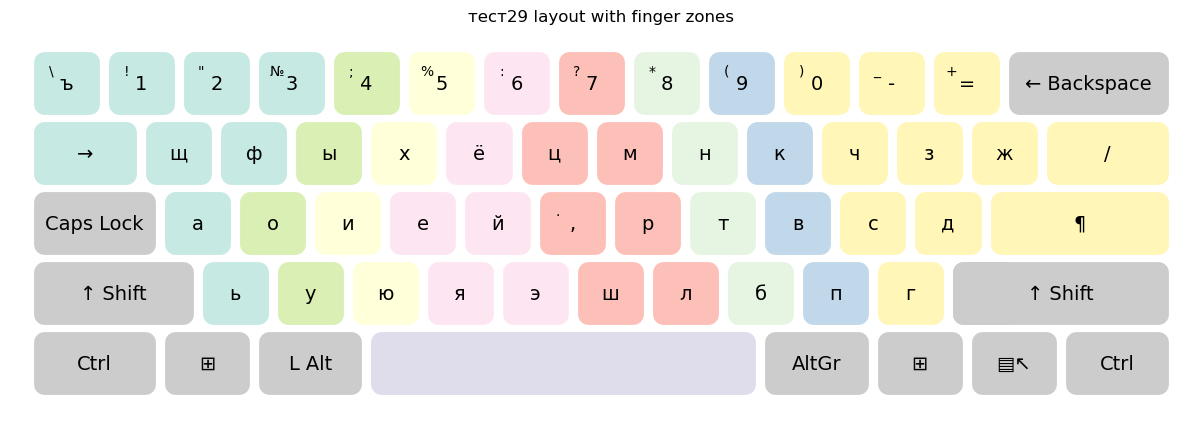

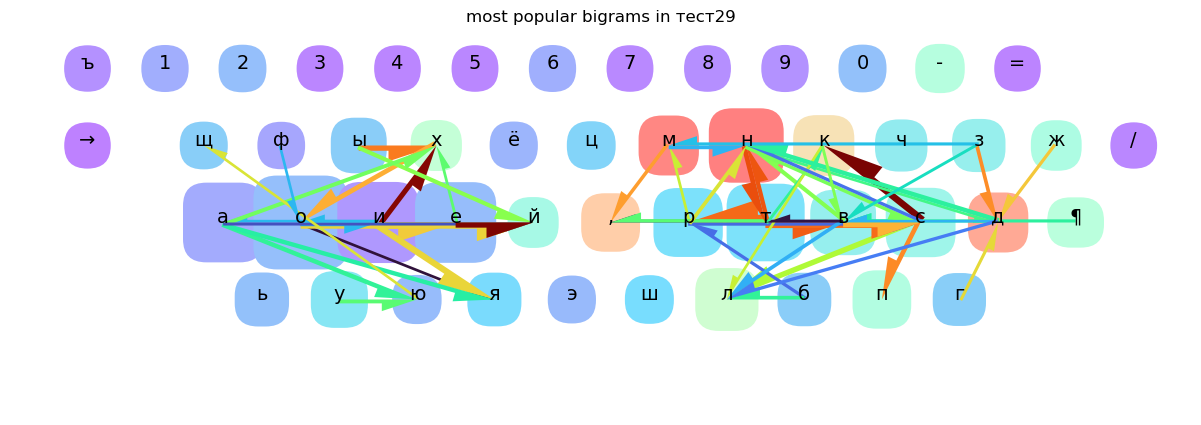

In [50]:
results['тест29'].display('layout', 'arrows')

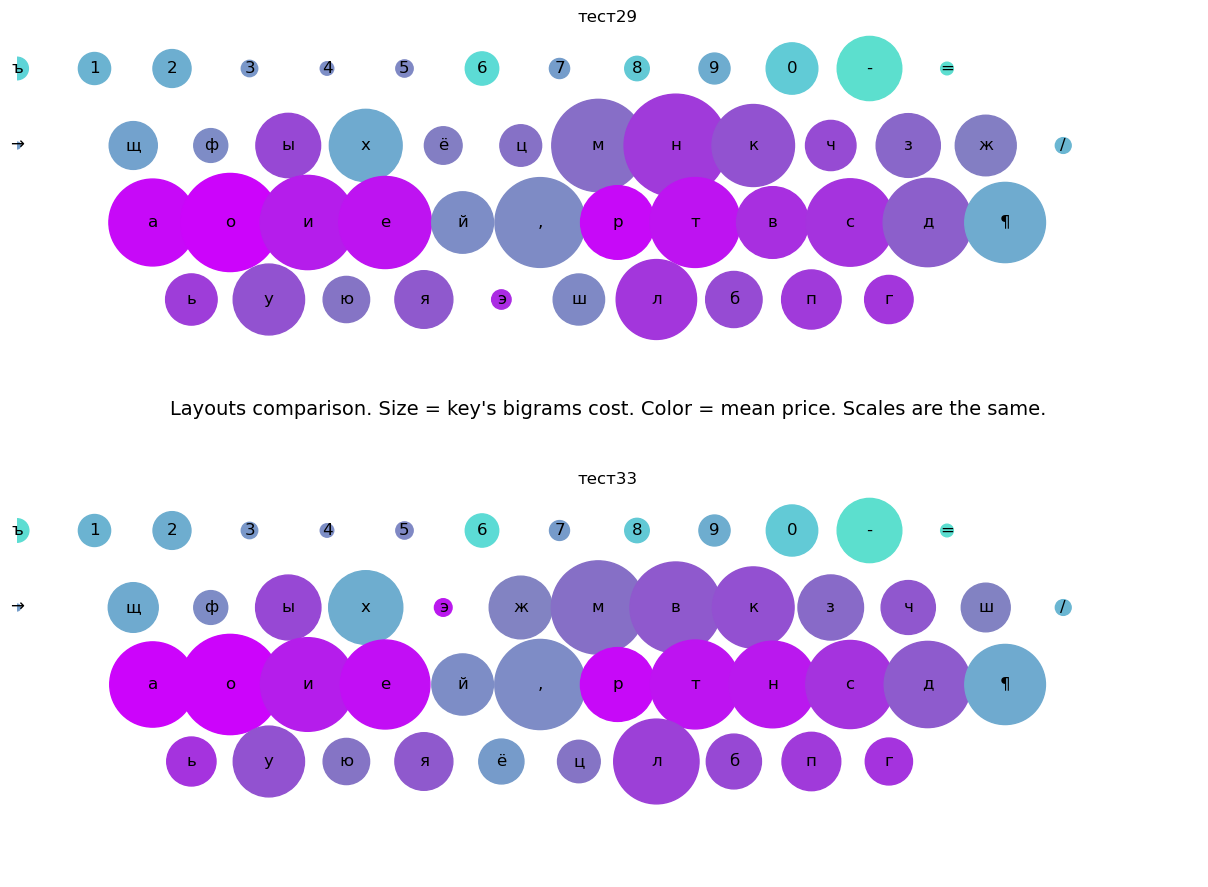

In [63]:
results['тест29'].combomap(results['тест33'])

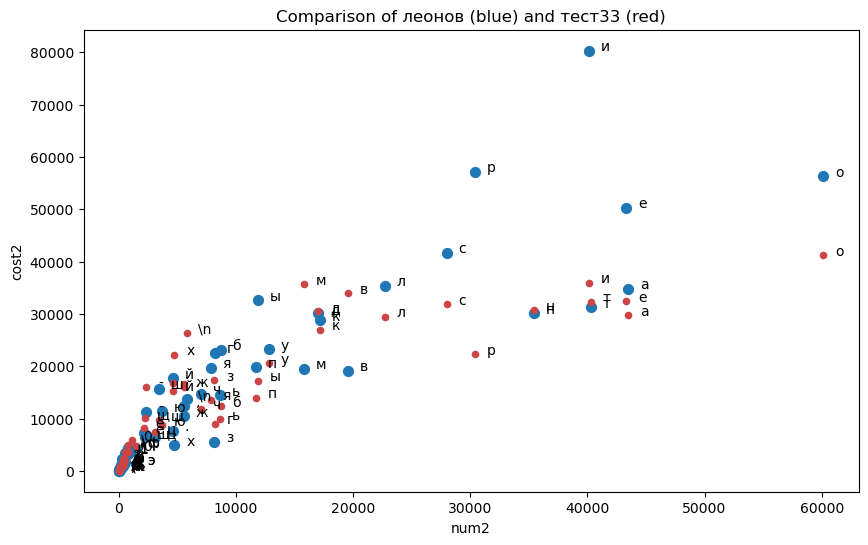

In [60]:
results['леонов'].combochart(results['тест33'])

# Final Standings <a name="standings">

In [61]:
print('Standard keyboard league:\n')
chosen_kbd = [
    ('йцукен', 'Default Russian kbd'),
    ('usphonetic', 'QWERTY transit'),
    ('rusdvorak', 'Dvorak translit'),
    ('диктор', 'Dictor'),
    ('зубачёв', 'Zubachov'),
    ('скоропис', 'Skoropis'),
    ('ант', 'ANT'),
    ('ugnvs', 'UGNVS'),
    ('леонов', 'Leonov'),
    ('тест1', 'Def.Rus with couple of letters swapped'),
    ('тест2', 'My first Dvorak analog'),
    ('тест9', 'First hand-tested'),
    ('тест10', 'First optimized after hand testing'),
    ('ино1', 'Alien #1, rare letters on AltGr'),
    ('тест33', 'Best and currently in use on my laptop'),
    ('ино2', 'Alien #2, many counterparts on AltGr'),
]
print(
    pd.DataFrame([(k, results[k].score.round(3), d) for k, d in chosen_kbd],
        columns=['layout', 'score', 'comment']).sort_values('score', ascending=True)
    .to_markdown(index=False)
)

print('\nErgodox league:\n')
chosen_kbd = [
    ('optozorax', 'ErgoDox Moonlander, alien'),
    ('ergodox', 'Stardand Russian on Ergodox'),
    ('тест33эрго', 'My best layout minimally adapted to Ergodox'),
]
print(
    pd.DataFrame([(k, results[k].score.round(3), d) for k, d in chosen_kbd],
        columns=['layout', 'score', 'comment']).sort_values('score', ascending=True)
    .to_markdown(index=False)
)

# how well I am against Leonov's layout (the best of eariler authors' layouts)
print('\nimprovement over Leonov\'s layout', round(1 - results['тест31'].score / results['леонов'].score, 3))

Standard keyboard league:

| layout     |   score | comment                                |
|:-----------|--------:|:---------------------------------------|
| ино2       |   0.94  | Alien #2, many counterparts on AltGr   |
| тест33     |   1.115 | Best and currently in use on my laptop |
| ино1       |   1.124 | Alien #1, rare letters on AltGr        |
| леонов     |   1.245 | Leonov                                 |
| зубачёв    |   1.341 | Zubachov                               |
| скоропис   |   1.351 | Skoropis                               |
| диктор     |   1.383 | Dictor                                 |
| тест10     |   1.527 | First optimized after hand testing     |
| тест9      |   1.538 | First hand-tested                      |
| ант        |   1.562 | ANT                                    |
| rusdvorak  |   1.569 | Dvorak translit                        |
| ugnvs      |   1.789 | UGNVS                                  |
| тест2      |   2.194 | My first Dvorak analog  

# Test Your Layout Here <a name="your-layout">
    
To measure this for a different keyboard, or different fingers positions, add Keyboard instance:
```python
'my_layout': (r'''
<layout definition>
''', Keyboard('my_special_kbd', ''' 
000012 3678999
000123 66789999
 01233 6678999
 01233 667899
4
''', '''
864222 4222468
622123 43112246
 00002 2000024
 11114 411112
0
'''))
```

To the results above: the Test27 layout seems very good, and I use it to type in Russian sometimes, but there's still some awkwardness to it. And it actually has much disbalance to the right hand. It's 20% more loaded and gets 80% more penalties.

IDK if I made something useful or just abuse my own scoring system.

In [64]:
lyt = Layout('тест34', r'''

ъ12345 67890-=
→щфыхэ цмвкчз,/
 аоией жртнсд¶
 ьуюяё шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅.∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''')


results[lyt.name] = r = Result(CORP, lyt)
print(lyt.name, ':', round(r.score, 3), '')

тест34 : 1.174 


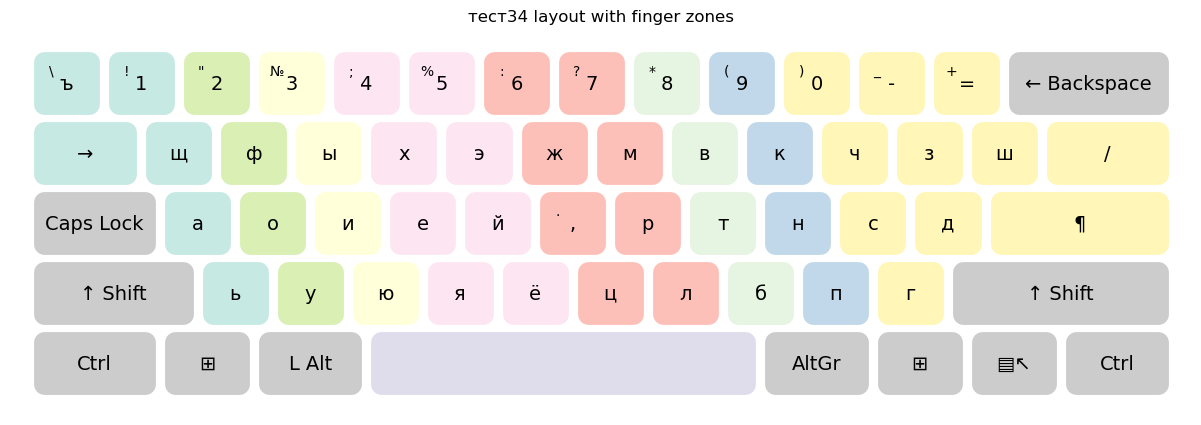

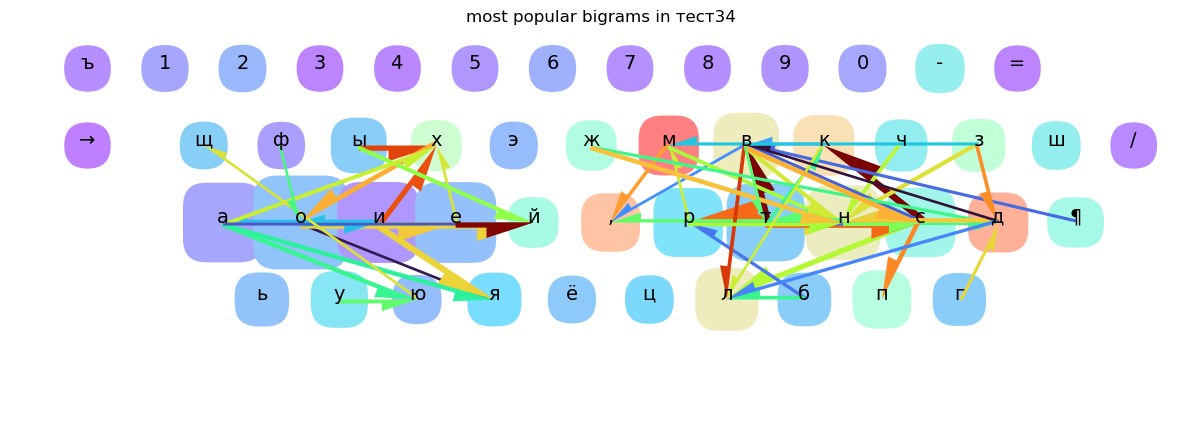

In [25]:
r.display('layout','arrows')

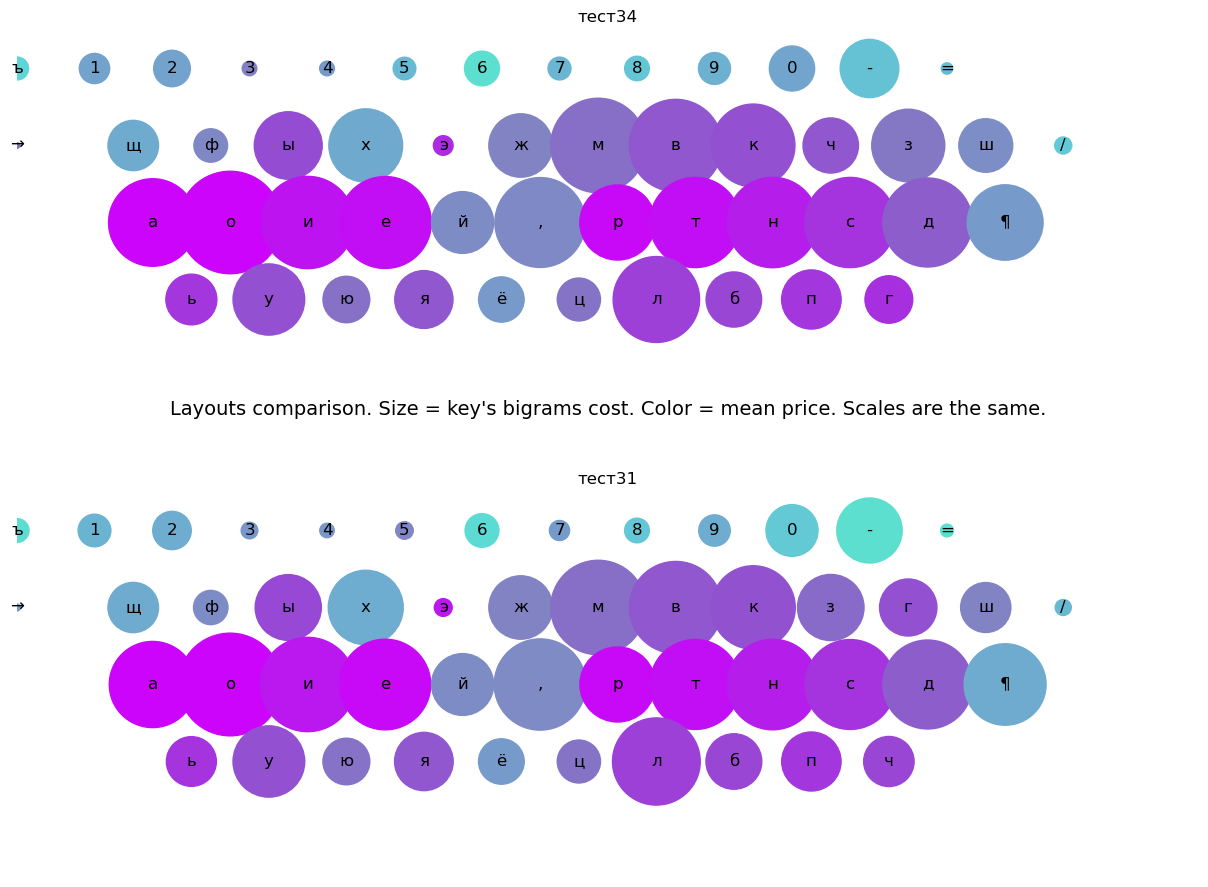

In [26]:
r.combomap(results['тест31'])

## Compare with others <a name="compare">

See what has changed, what bigrams degraded, and what were benefitial.

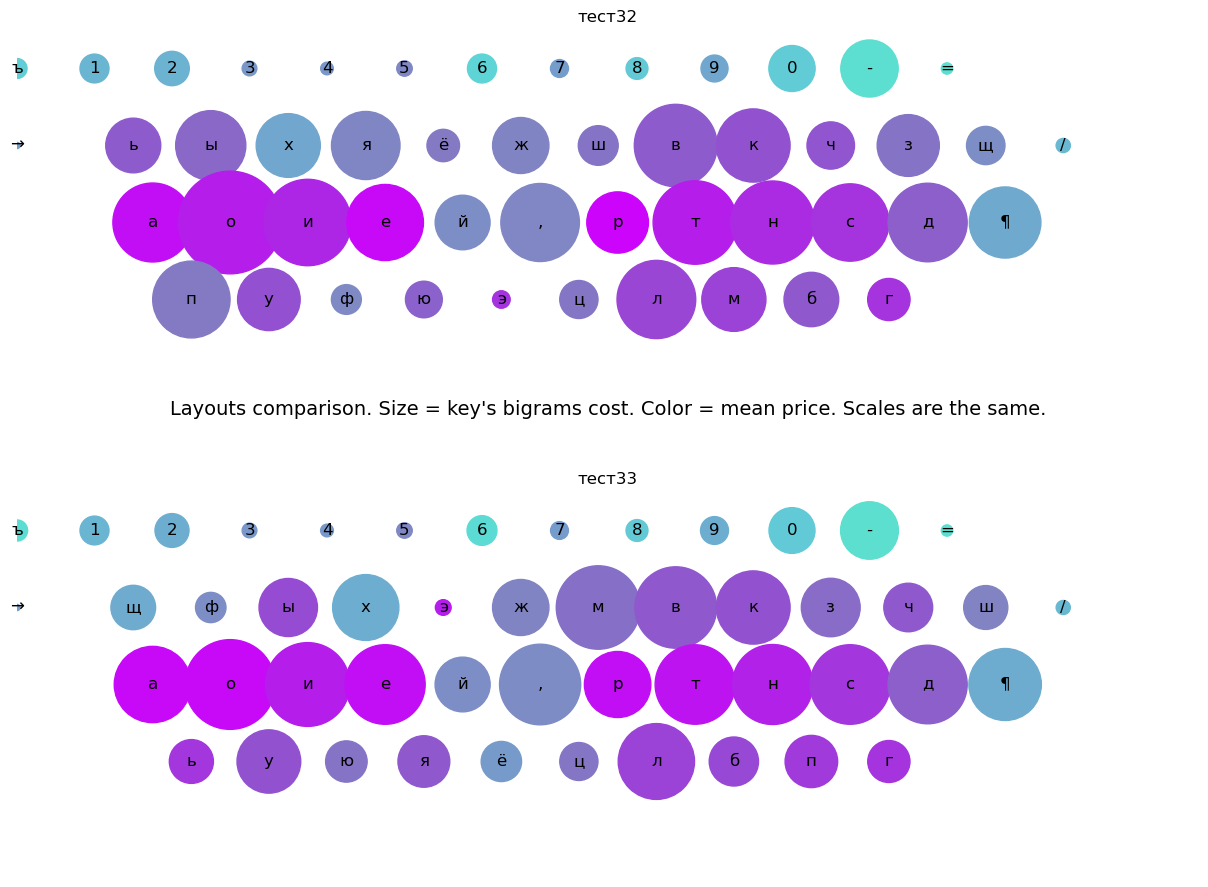

In [27]:
results['тест32'].combomap(results['тест33'])

## Losses

In [28]:
compare(results, 'тест32', 'тест33').head(30)

bigram   num                     category_old  price_old  cost_old  \
25      ⌴м  2178                        space bar          1      2178   
191     ом  1719                     altern hands          1      1719   
41      пр  2820                     altern hands          0         0   
102     ем  1336                     altern hands          1      1336   
302     сп   628                     altern hands          1       628   
106     им  1168                     altern hands          1      1168   
111     их   776             out, over one finger          5      3880   
299     ам  1101                     altern hands          1      1101   
192     м,   365  in, adj finger, same or adj row          4      1460   
379     ющ   208                     altern hands          4       832   
435     ию   199                    in, lower row          2       398   
331     ущ   122                     altern hands          4       488   
378     ую   447      in, over 1 finger, same row          1       447   
239     ым   437                     altern hands          1       437   
146     рм   216             out, over one finger          5      1080   
916     ща   141                     altern hands          0         0   
346     бл   398      in, over 1 finger, same row          1       398   
611     щё   151                     altern hands          3       453   
223     мп    94                     altern hands          1        94   
473     ях   106             out, over one finger          5       530   
54      ¶п   166                     altern hands          1       166   
949     ёх    93             out, over one finger          5       465   
424     м.   158  in, adj finger, same or adj row          4       632   
351     вп    57                     altern hands          1        57   
612     яе   113                    in, lower row          1       113   
362     ум   280                     altern hands          1       280   
824     пн    88                     altern hands          0         0   
353     -п    52                     altern hands          1        52   
408     чш    66      in, over 1 finger, same row          3       198   
973     оф   114                    in, lower row          2       228   

                        category_new  price_new  cost_new  delta  
25                         space bar          3      6534   4356  
191                     altern hands          3      5157   3438  
41        in, over 1 finger, adj row          1      2820   2820  
102                     altern hands          3      4008   2672  
302                   ring <-> pinky          5      3140   2512  
106                     altern hands          3      3504   2336  
111              same finger adj row          8      6208   2328  
299                     altern hands          3      3303   2202  
192              same finger adj row          8      2920   1460  
379        over 1 finger, over 1 row         10      2080   1248  
435              same finger adj row          7      1393    995  
331              adj finger over row         12      1464    976  
378  in, adj finger, same or adj row          3      1341    894  
239                     altern hands          3      1311    874  
146              same finger adj row          9      1944    864  
916              same finger adj row          6       846    846  
346  in, adj finger, same or adj row          3      1194    796  
611        pinky -> index over 1 row          8      1208    755  
223        over 1 finger, over 1 row          9       846    752  
473              adj finger over row         12      1272    742  
54                    ring <-> pinky          5       830    664  
949              adj finger over row         12      1116    651  
424              same finger adj row          8      1264    632  
351              adj finger over row         11       627    570  
612              same finger adj r

## Gains

In [29]:
compare(results, 'тест32', 'тест33').tail(30)

bigram   num                     category_old  price_old  cost_old  \
96      оя   216  in, adj finger, same or adj row          4       864   
316     ох   177              same finger adj row          7      1239   
410     ип   139             out, over one finger          5       695   
277     ая   572       in, over 1 finger, adj row          3      1716   
339     ля   620                     altern hands          2      1240   
157     ты   664                     altern hands          2      1328   
70      ры   665                     altern hands          2      1330   
224     пе   776       in, over 1 finger, adj row          1       776   
205     бы   820                     altern hands          2      1640   
71      ых   829                   ring <-> pinky          5      4145   
445     пы    95             same finger over row         10       950   
923     яю   100              adj finger over row         11      1100   
274     ах   479                   ring <-> pinky          5      2395   
182     ⌴э   983                        space bar          4      3932   
436     пу   248                   ring <-> pinky          5      1240   
112     вы  1020                     altern hands          2      2040   
265     фи   209              same finger adj row          6      1254   
131     ся  1192                     altern hands          2      2384   
194     хо   684              same finger adj row          6      4104   
159     уп   357                   ring <-> pinky          5      1785   
498     зм   290        over 1 finger, over 1 row          9      2610   
291     ап   336              same finger adj row          7      2352   
46      ль  2056                     altern hands          2      4112   
236     ны  2235                     altern hands          2      4470   
295     оп   568                   ring <-> pinky          5      2840   
38      ть  2493                     altern hands          2      4986   
188     бщ   231              adj finger over row         14      3234   
303     па   477              same finger adj row          6      2862   
262     ия  1139              same finger adj row          8      9112   
55      по  3115                   ring <-> pinky          4     12460   

                        category_new  price_new  cost_new  delta  
96        in, over 1 finger, adj row          2       432   -432  
316  in, adj finger, same or adj row          4       708   -531  
410                     altern hands          1       139   -556  
277       in, over 1 finger, adj row          2      1144   -572  
339                     altern hands          1       620   -620  
157                     altern hands          1       664   -664  
70                      altern hands          1       665   -665  
224                     altern hands          0         0   -776  
205                     altern hands          1       820   -820  
71   in, adj finger, same or adj row          4      3316   -829  
445                     altern hands          1        95   -855  
923           index->middle same row          2       200   -900  
274       in, over 1 finger, adj row          3      1437   -958  
182                        space bar          3      2949   -983  
436                     altern hands          1       248   -992  
112                     altern hands          1      1020  -1020  
265       in, over 1 finger, adj row          1       209  -1045  
131                     altern hands          1      1192  -1192  
194             out, over one finger          4      2736  -1368  
159                     altern hands          1       357  -1428  
498      in, over 1 finger, same row          3       870  -1740  
291                     altern hands          1       336  -2016  
46                      altern hands          1      2056  -2056  
236                     altern hands          1      2235  -2235  
295                     altern han

You can save the comparison table to CSV:

In [30]:
compare(results, 'леонов', 'тест33').to_csv('leonov-test33.csv')

## Simple Statistics, What Cost The Most <a name="simple-stats">

In [31]:
results['тест33'].bigrams.sort_values('cost', ascending=False).head(30) #.to_csv('/tmp/test26.csv')

bigram   num l1 l2 t1 t2      freq  price_l2  price_di  \
25      ⌴м  2178  ⌴  м  -  c  0.005564         3         0   
177     .¶  1085  .  ¶  -  -  0.002772         4         2   
49      тв   926  т  в  c  c  0.002365         1         6   
114     ск  1284  с  к  c  c  0.003280         1         4   
296     ей   790  е  й  v  c  0.002018         2         6   
111     их   776  и  х  v  c  0.001982         2         6   
40      ⌴п  5662  ⌴  п  -  c  0.014463         1         0   
124     ⌴-   886  ⌴  -  -  -  0.002263         6         0   
191     ом  1719  о  м  v  c  0.004391         3         0   
227     ⌴д  2489  ⌴  д  -  c  0.006358         2         0   
18      ⌴в  4955  ⌴  в  -  c  0.012657         1         0   
195     од  2317  о  д  v  c  0.005919         2         0   
338     вл   403  в  л  c  c  0.001029         1        10   
53      ¶¶  1033  ¶  ¶  -  -  0.002639         4         0   
102     ем  1336  е  м  v  c  0.003413         3         0   
78      тр  1768  т  р  c  c  0.004516         0         2   
130     тс   879  т  с  c  c  0.002245         0         4   
106     им  1168  и  м  v  c  0.002984         3         0   
71      ых   829  ы  х  v  c  0.002118         2         2   
299     ам  1101  а  м  v  c  0.002812         3         0   
2       ож   804  о  ж  v  c  0.002054         4         0   
35      ов  3193  о  в  v  c  0.008156         1         0   
302     сп   628  с  п  c  c  0.001604         1         4   
447     зд   390  з  д  c  c  0.000996         2         6   
182     ⌴э   983  ⌴  э  -  v  0.002511         3         0   
133     ⌴ч  1466  ⌴  ч  -  c  0.003745         2         0   
192     м,   365  м  ,  c  -  0.000932         2         6   
41      пр  2820  п  р  c  c  0.007204         0         1   
94      ⌴з  1384  ⌴  з  -  c  0.003535         2         0   
30      ⌴к  2760  ⌴  к  -  c  0.007050         1         0   

                            category  price  cost  finger  column  row   h1  \
25                         space bar      3  6534     6.0     8.0  1.0  0.0   
177                   index -> pinky      6  6510     9.0    13.0  2.0  1.0   
49               same finger adj row      7  6482     7.0     9.0  1.0  1.0   
114                   ring <-> pinky      5  6420     8.0    10.0  1.0  1.0   
296              same finger adj row      8  6320     3.0     5.0  2.0  0.0   
111              same finger adj row      8  6208     2.0     4.0  1.0  0.0   
40                         space bar      1  5662     8.0    10.0  3.0  0.0   
124                        space bar      6  5316     9.0    12.0  0.0  0.0   
191                     altern hands      3  5157     6.0     8.0  1.0  0.0   
227                        space bar      2  4978     9.0    12.0  2.0  0.0   
18                         space bar      1  4955     7.0     9.0  1.0  0.0   
195                     altern hands      2  4634     9.0    12.0  2.0  0.0   
338              adj finger over row     11  4433     6.0     8.0  3.0  1.0   
53                          same key      4  4132     9.0    13.0  2.0  1.0   
102                     altern hands      3  4008     6.0     8.0  1.0  0.0   
78   in, adj finger, same or adj row      2  3536     6.0     8.0  2.0  1.0   
130             out, over one finger      4  3516     9.0    11.0  2.0  1.0   
106                     altern hands      3  3504     6.0     8.0  1.0  0.0   
71   in, adj finger, same or adj row      4  3316     2.0     4.0  1.0  0.0   
299                     altern hands      3  3303     6.0     8.0  1.0  0.0   
2                       altern hands      4  3216     6.0     7.0  1.0  0.0   
35                      altern hands      1  3193     7.0     9.0  1.0  0.0   
302                   ring <-> pinky      5  3140     8.0    10.0  3.0  1.0   
447              same finger adj row      8  3120     9.0    12.0  2.0  1.0   
182                        space bar      3  2949     3.0     5.0  1.0  0.0   
133                        

## Statistics of Bigrams to CSV <a name="output-statistics">

We count how often a key comes before or after which one. We add categories to simplify statistics analysis: vowel/consonant/other, hand (in layout 27), row, column. 

In [32]:
key = 'тест33' # the output file will be 'all-letters-melt-<key>.csv'
res = results[key]


BG = CORP.bigrams
km = res.layout.keymap
dg2 = BG[BG.l1.isin(BASE_KEYS) & BG.l2.isin(BASE_KEYS)].copy()
dg2['kind_after'] = dg2.t2
dg2['row1'] = dg2.l1.map(km['row'])
dg2['row2'] = dg2.l2.map(km['row'])
dg2['hand1'] = dg2.l1.map(km['hand']).map({0: 'left', 1: 'right'})
dg2['hand2'] = dg2.l2.map(km['hand']).map({0: 'left', 1: 'right'})
dg2['dir'] = 'before'
dg2['kind_before'] = dg2.t1
dg2['letter_before'] = dg2.t1.isin(['v', 'c'])
dg2['hand'] = dg2.hand1
dg2['row'] = dg2.row1
dg2['letter_after'] = dg2.t2.isin(['v', 'c'])
pd1 = dg2.rename(columns={'l1': 'prev', 'l2': 'letter'}
        ).pivot_table('num', 'letter', ['dir', 'kind_before', 'hand', 'row', 'prev'], fill_value=0)

dg2['dir'] = 'after'
dg2['hand'] = dg2.hand2
dg2['row'] = dg2.row2

pd2 = dg2.rename(columns={'l2': 'next', 'l1': 'letter'}
                ).pivot_table('num', 'letter', ['dir', 'kind_after', 'hand', 'row', 'next'], fill_value=0)
dg3 = pd1.join(pd2) #.reset_index()

dg3.melt(ignore_index=False).reset_index().rename(
    columns={'variable_0': 'where', 'variable_1': 'ftype', 'variable_4': 'other', 
             'variable_2': 'hand', 'variable_3': 'row', 'value': 'num',
            'letter': 'letter'}).to_csv(f'all-letters-melt-{key}.csv')

## Check the keymap (for errors) <a name="keymap">

In [33]:
lyt.keymap
# or 
# results['тест28'][1]

layer  row  column  key_count  finger  ftype  hand  penalty
ъ      0    0       0          1       0      4     0        7
1      0    0       1          1       0      4     0        5
2      0    0       2          1       1      3     0        3
3      0    0       3          1       2      2     0        2
4      0    0       4          1       3      1     0        4
5      0    0       5          1       3      1     0        6
6      0    0       7          1       6      1     1        6
7      0    0       8          1       6      1     1        4
8      0    0       9          1       7      2     1        2
9      0    0      10          1       8      3     1        2
0      0    0      11          1       9      4     1        2
-      0    0      12          1       9      4     1        4
=      0    0      13          1       9      4     1        6
→      0    1       0          1       0      4     0        3
щ      0    1       1          1       0      4     0        2
ф      0    1       2          1       1      3     0        1
ы      0    1       3          1       2      2     0        1
х      0    1       4          1       3      1     0        3
э      0    1       5          1       3      1     0        4
ж      0    1       7          1       6      1     1        4
м      0    1       8          1       6      1     1        3
в      0    1       9          1       7      2     1        1
к      0    1      10          1       8      3     1        1
ч      0    1      11          1       9      4     1        2
з      0    1      12          1       9      4     1        3
ш      0    1      13          1       9      4     1        5
/      0    1      14          1       9      4     1        7
а      0    2       1          1       0      4     0        0
о      0    2       2          1       1      3     0        0
и      0    2       3          1       2      2     0        0
е      0    2       4          1       3      1     0        0
й      0    2       5          1       3      1     0        2
,      0    2       7          1       6      1     1        2
р      0    2       8          1       6      1     1        0
т      0    2       9          1       7      2     1        0
н      0    2      10          1       8      3     1        0
с      0    2      11          1       9      4     1        0
д      0    2      12          1       9      4     1        2
¶      0    2      13          1       9      4     1        3
ь      0    3       1          1       0      4     0        1
у      0    3       2          1       1      3     0        1
ю      0    3       3          1       2      2     0        1
я      0    3       4          1       3      1     0        1
ё      0    3       5          1       3      1     0        4
ц      0    3       7          1       6      1     1        4
л      0    3       8          1       6      1     1        1
б      0    3       9          1       7      2     1        1
п      0    3      10          1       8      3     1        1
г      0    3      11          1       9      4     1        1
⌴      0    4       0          1       4      0     0        0
\      1    0       0          1       0      4     0        7
!      1    0       1          1       0      4     0        5
"      1    0       2          1       1      3     0        3
№      1    0       3          1       2      2     0        2
;      1    0       4          1       3      1     0        4
%      1    0       5          1       3      1     0        6
:      1    0       7          1       6      1     1        6
?      1    0       8          1       6      1     1        4
*      1    0       9          1       7      2     1        2
(      1    0      10          1       8      3     1        2
)      1    0      11          1       9      4     1        2
_      1    0      12          1       9      4     1        4
+      1    0      13          1  

# Ergodox League <a name="ergodox">

Let's compare the standard layout on Ergodox with Optozorax' one.
    
The first test here showed that I got finger numbers wrong in `ERGODOX`, that's why this is also helpful.

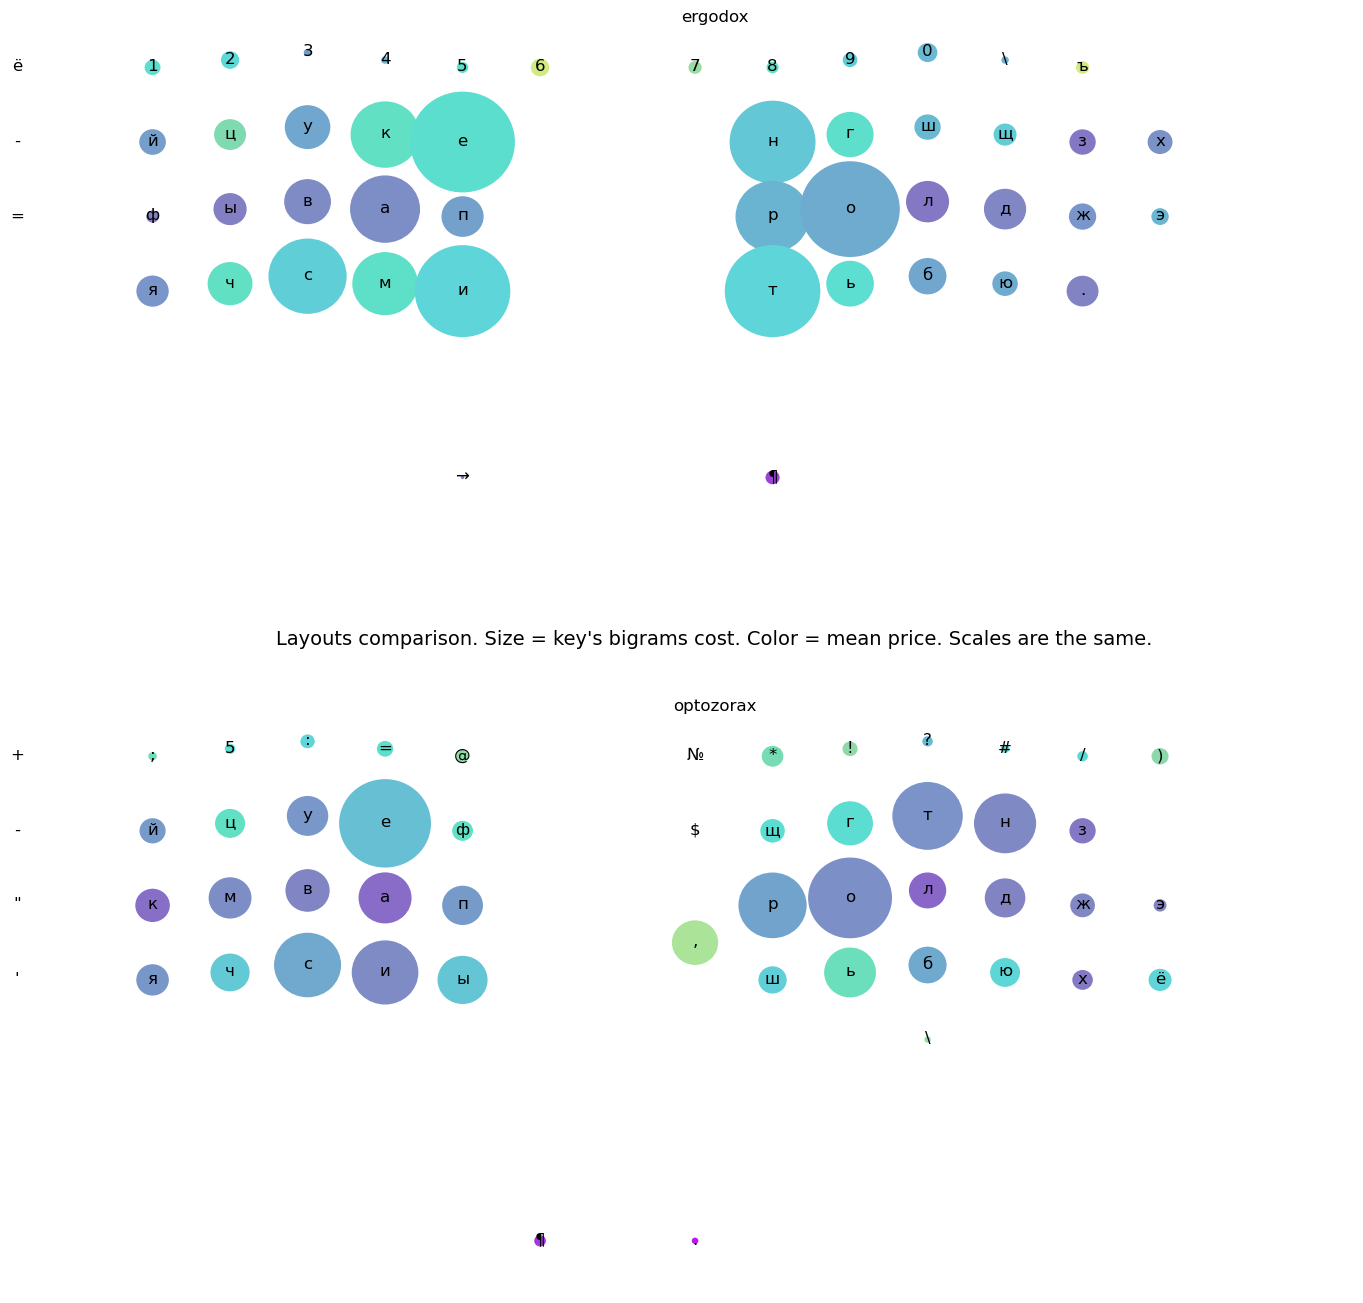

In [34]:
results['ergodox'].combomap(results['optozorax'])

As we can see in the map above, йцукен on Ergodox is harder in most keys. Let's see what letters were improved actually:

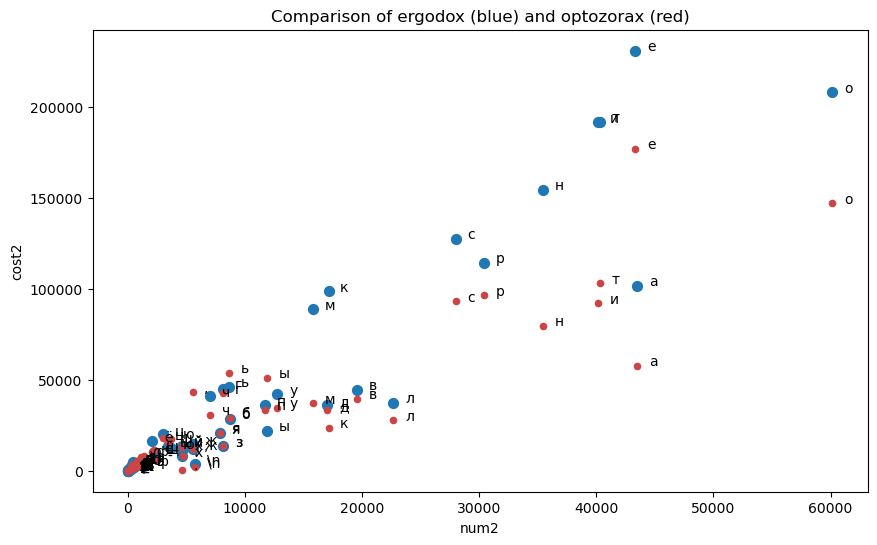

In [35]:
results['ergodox'].combochart(results['optozorax'])

But you may notice that Optozorax' layout is actually a modest modification of the standard ЙЦУКЕН. How far can we improve it? I've simply translated my test28, moving the rightmost letter Ж to the left side, and slash to up-right corner. The result scores 2.5 times better.

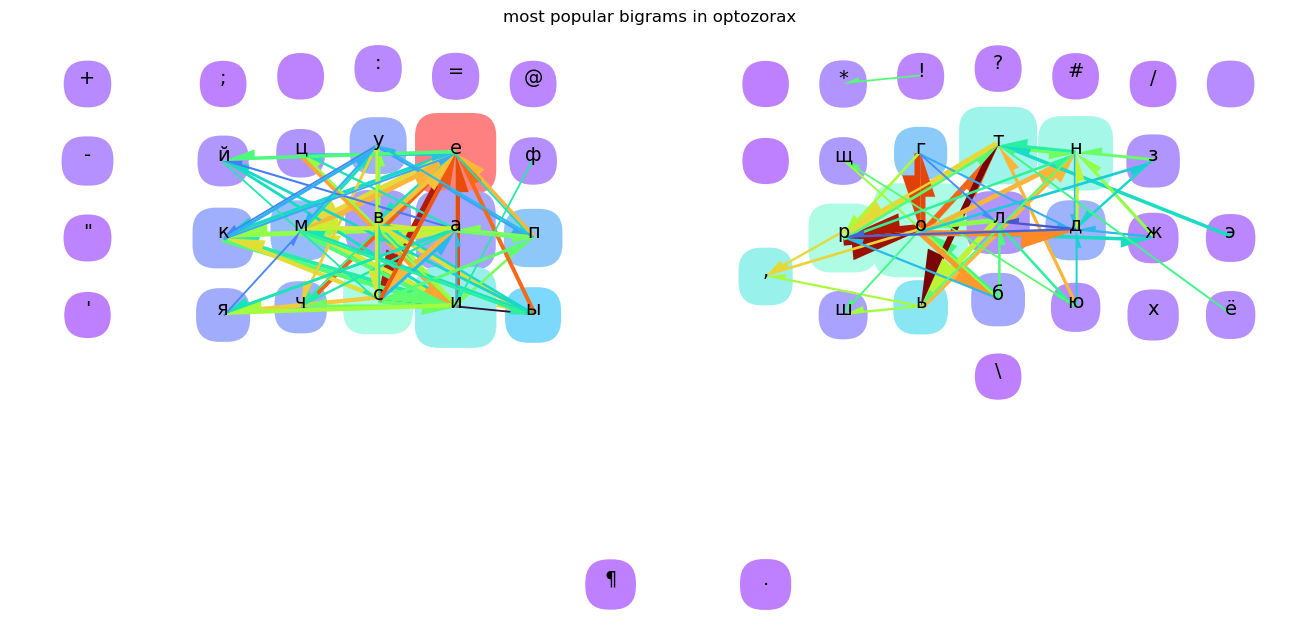

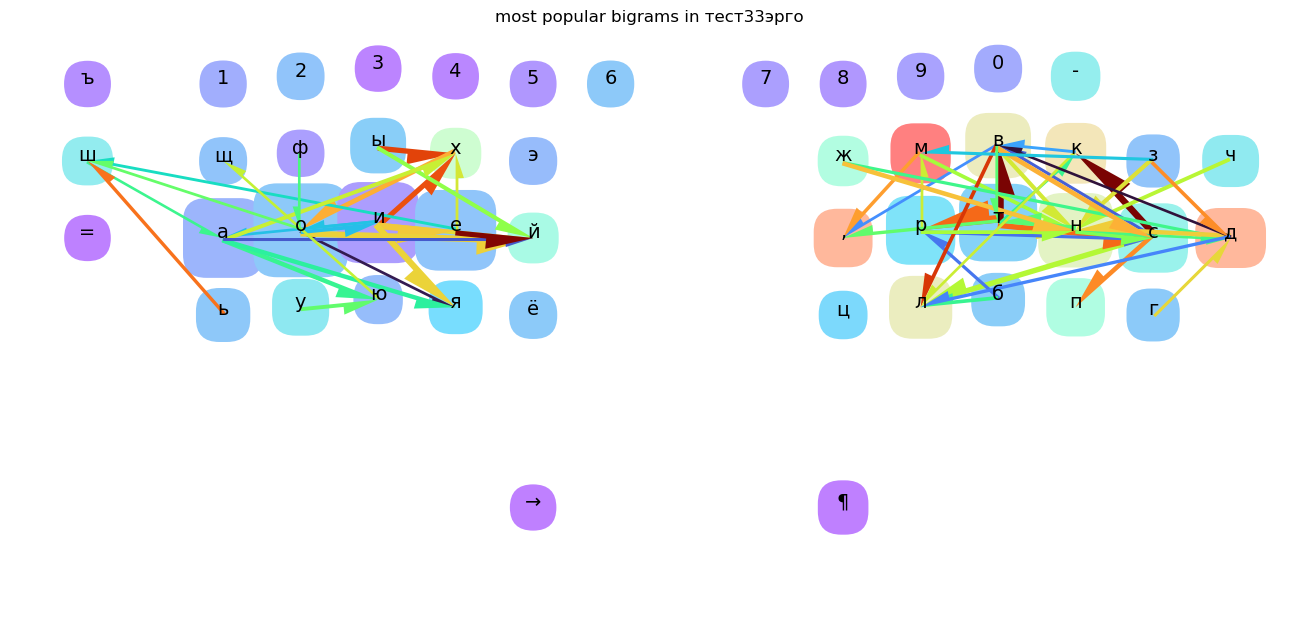

In [36]:
results['optozorax'].display('arrows')
results['тест33эрго'].display('arrows')


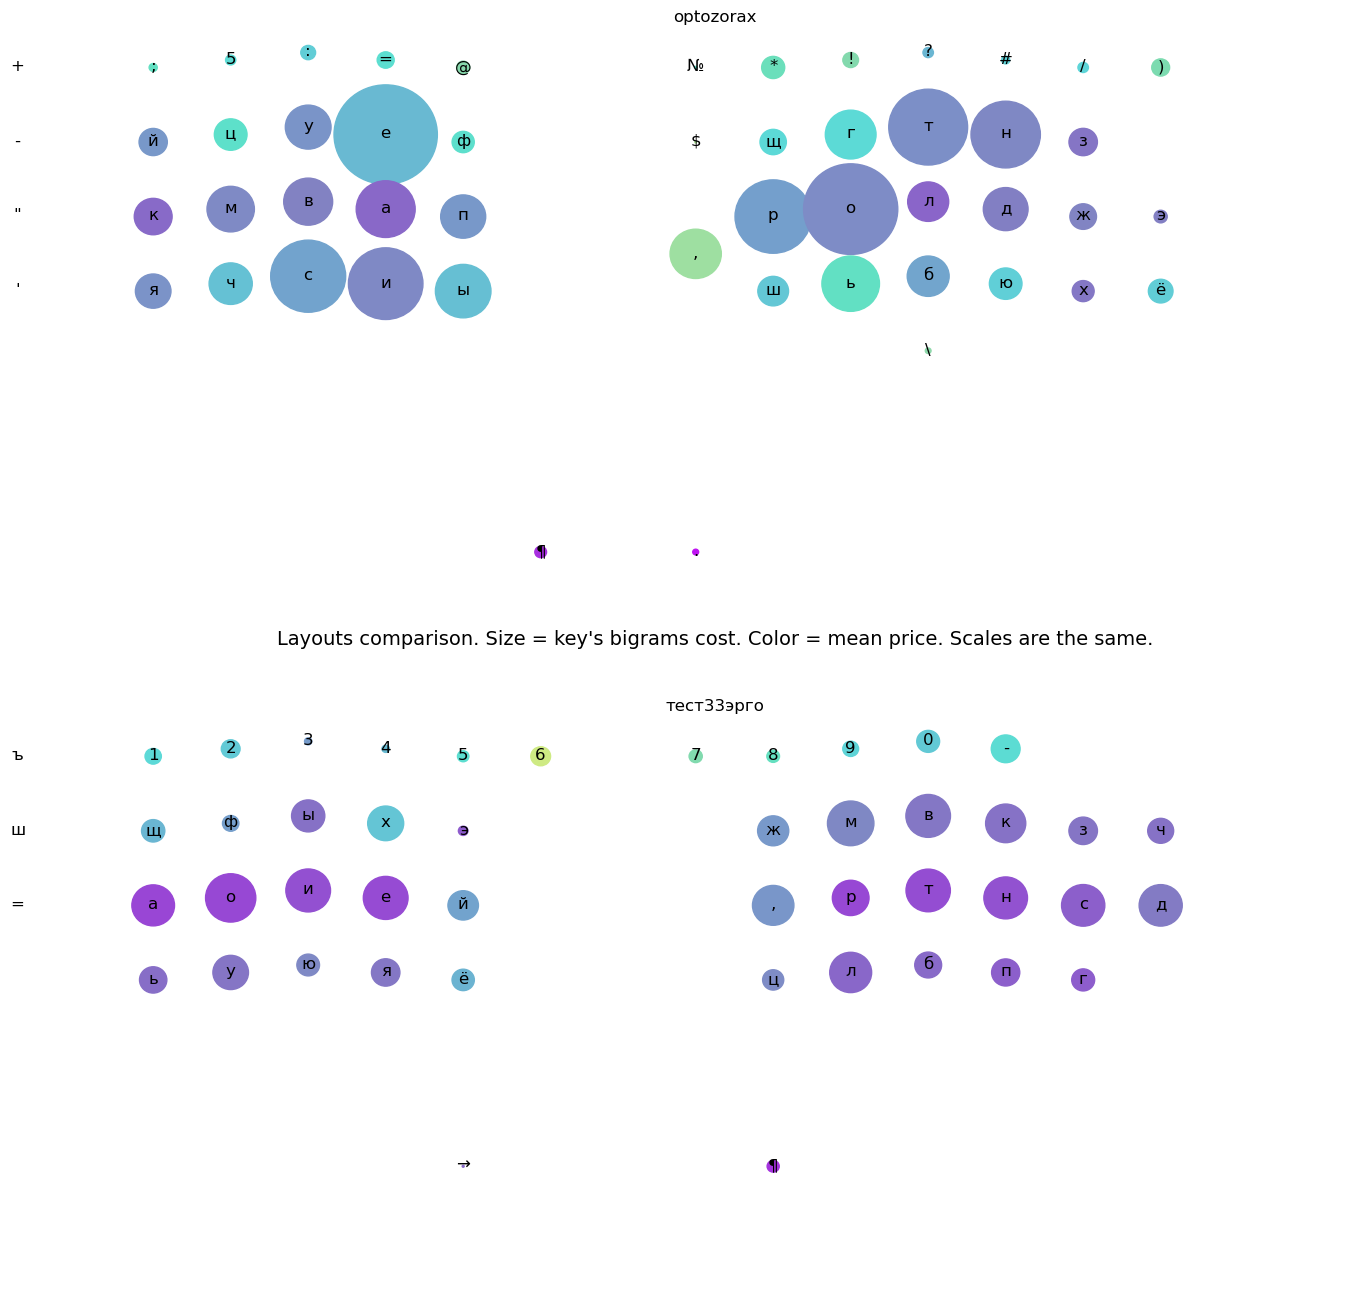

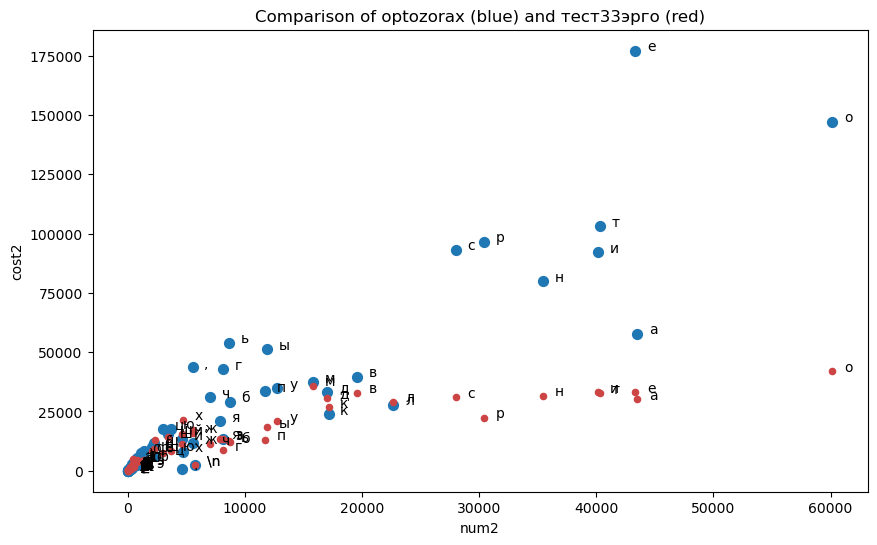

In [37]:
results['optozorax'].combomap(results['тест33эрго'])
results['optozorax'].combochart(results['тест33эрго'])

# Heatmaps <a name="heatmaps">

To see the heatmap by just number of key presses, use `pivot_table('num'`, to see the one for penalties, use `pivot_table('cost'`.

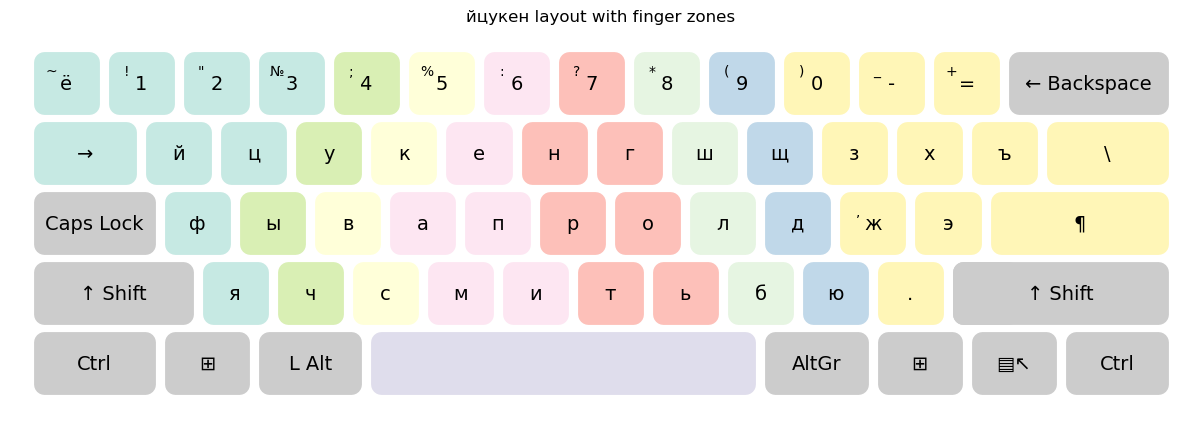

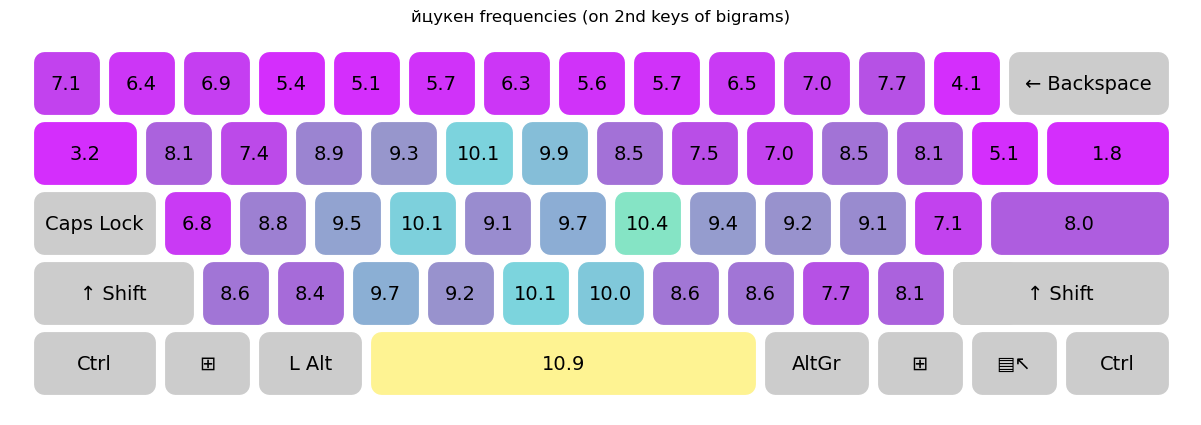

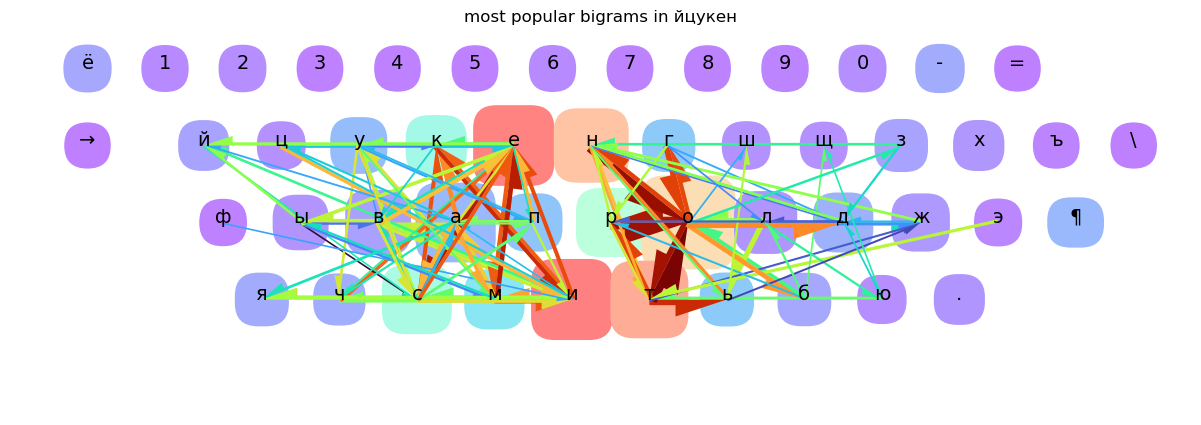

In [38]:
results['йцукен'].display('layout', 'num', 'arrows')

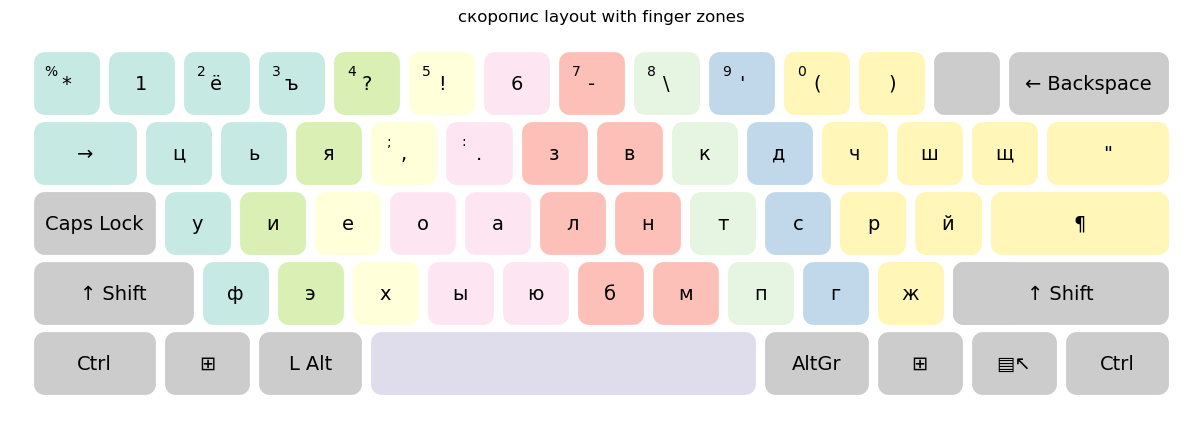

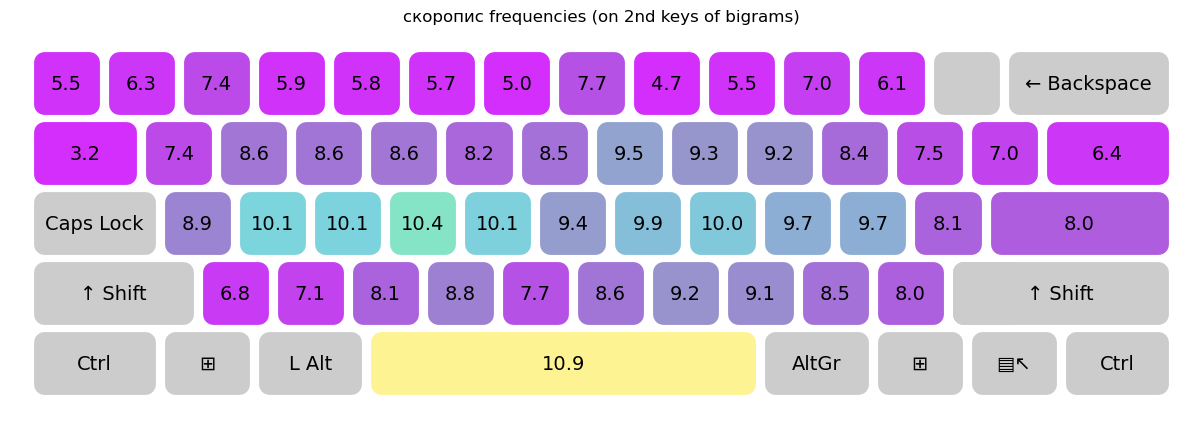

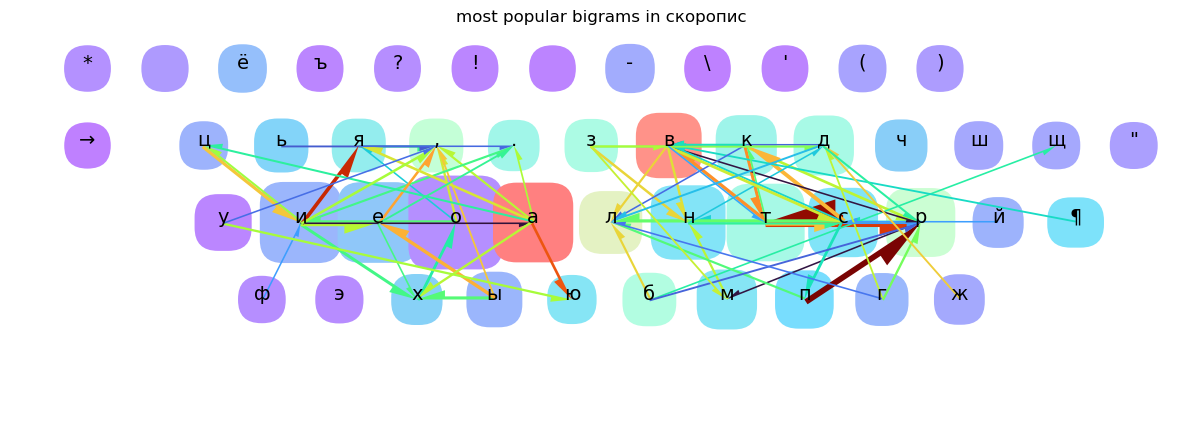

In [39]:
results['скоропис'].display('layout', 'num', 'arrows')

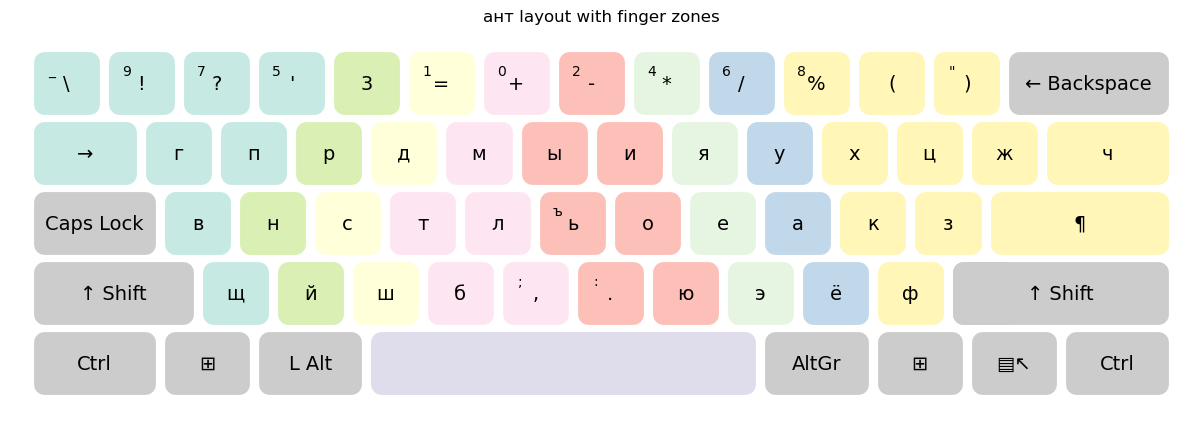

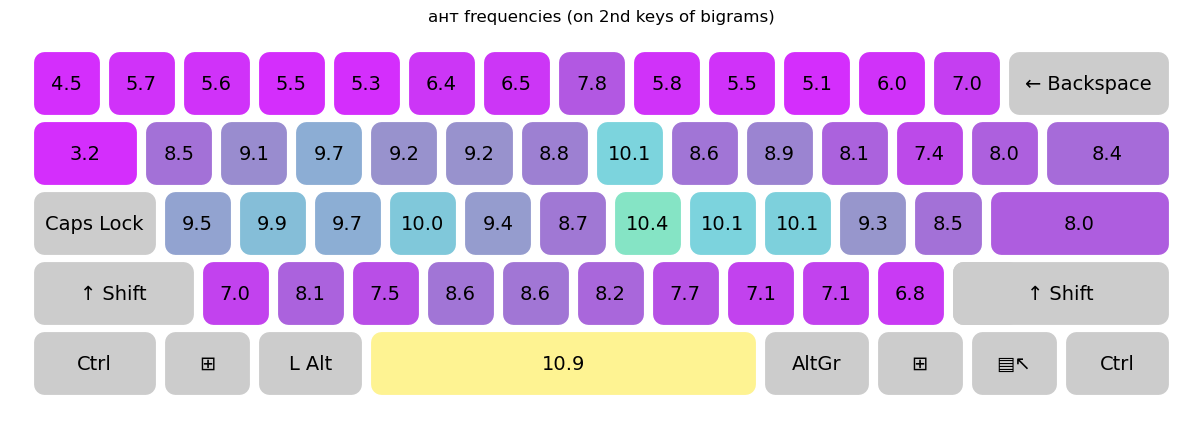

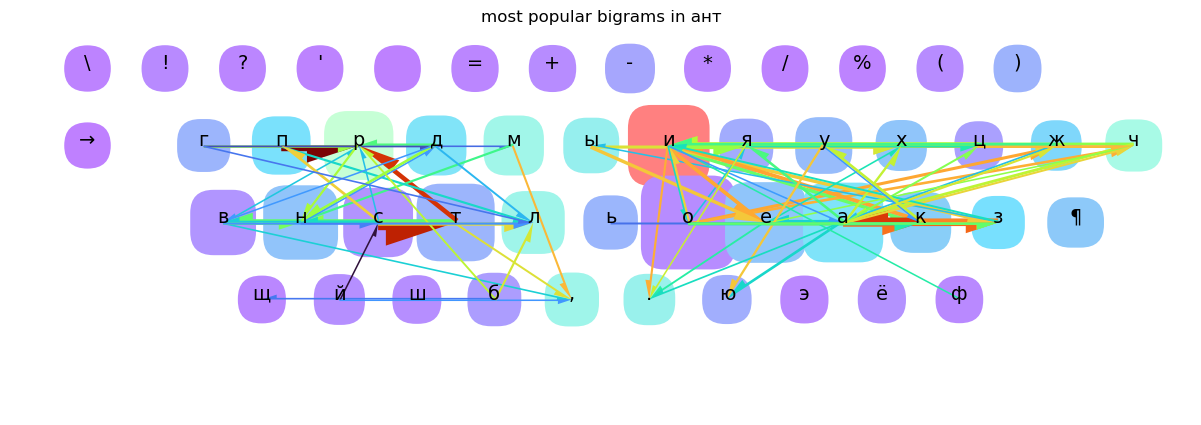

In [40]:
results['ант'].display('layout', 'num', 'arrows')

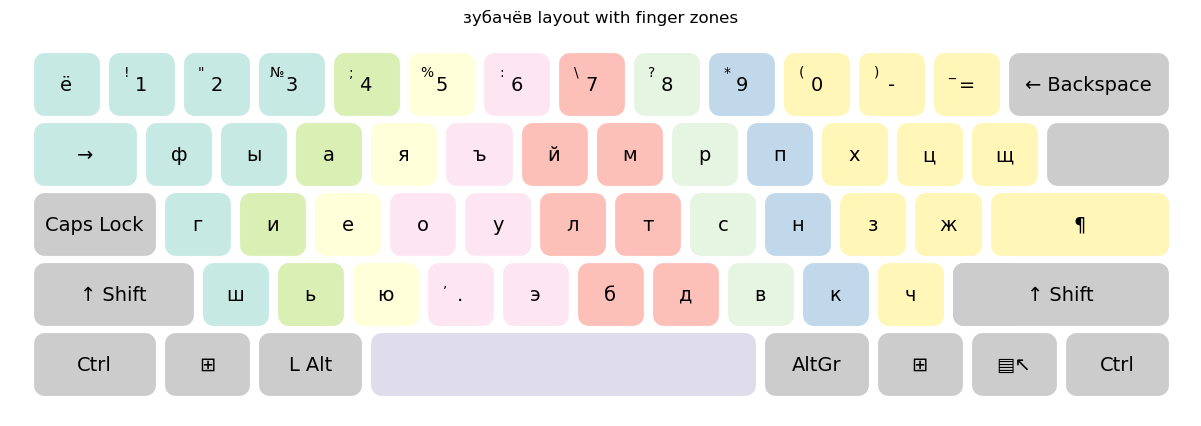

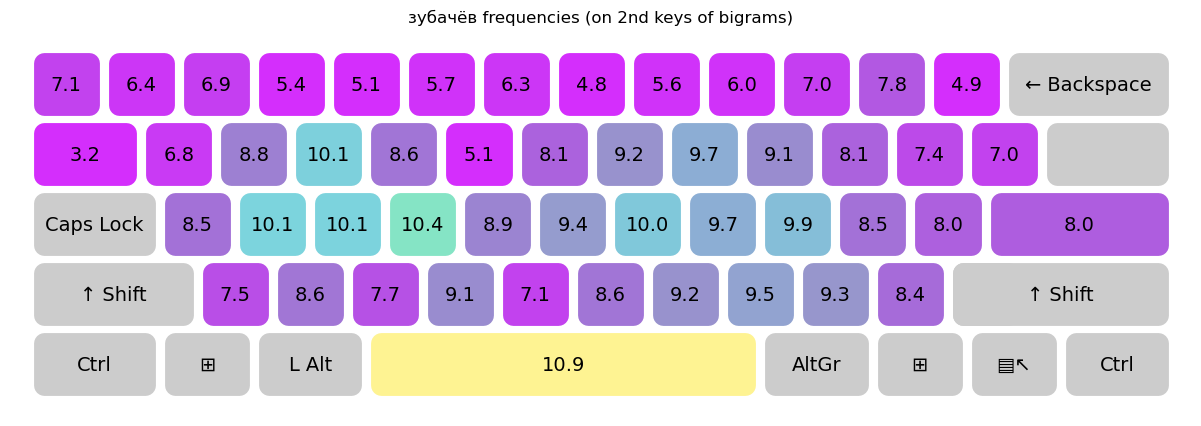

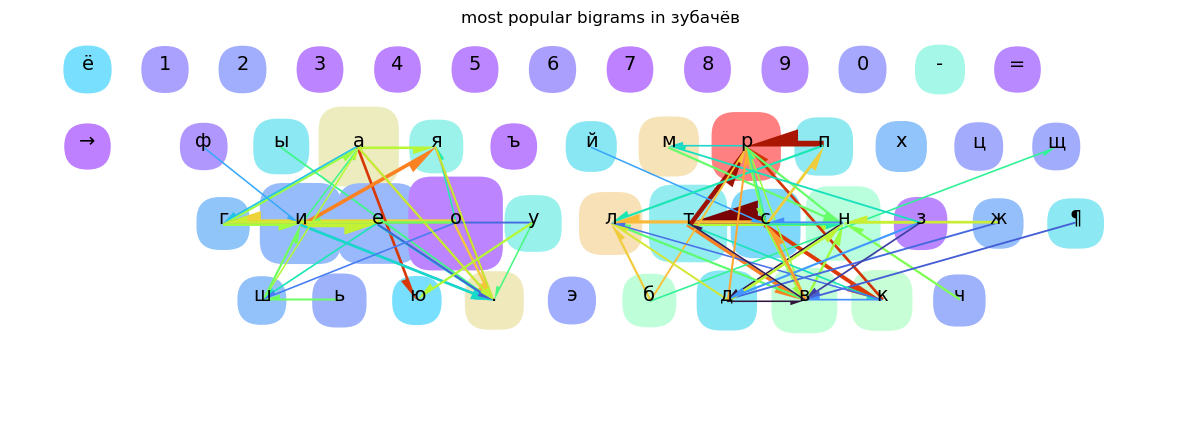

In [41]:
results['зубачёв'].display('layout', 'num', 'arrows')

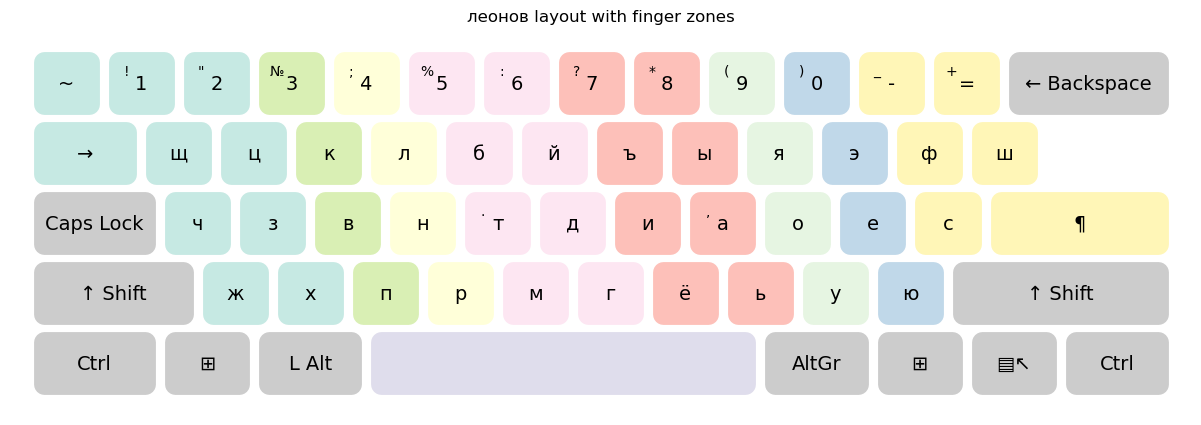

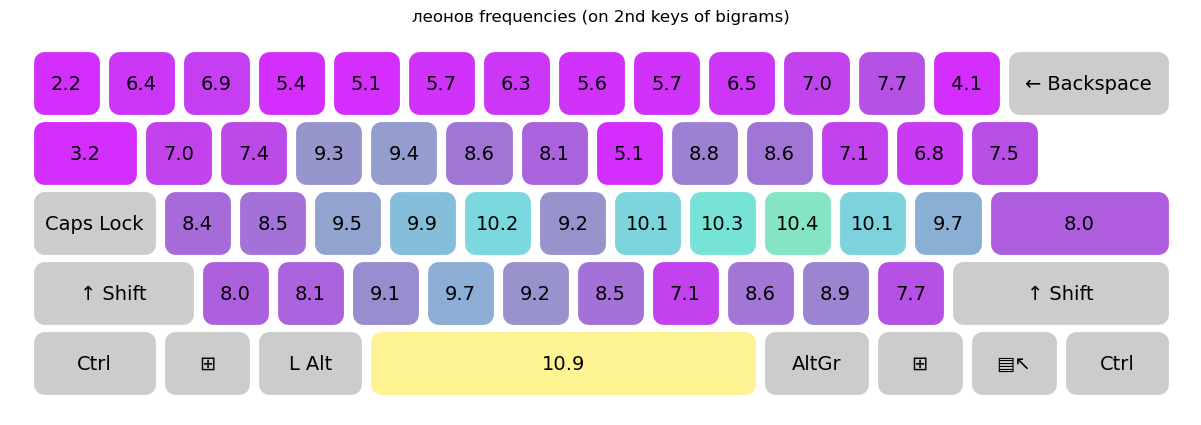

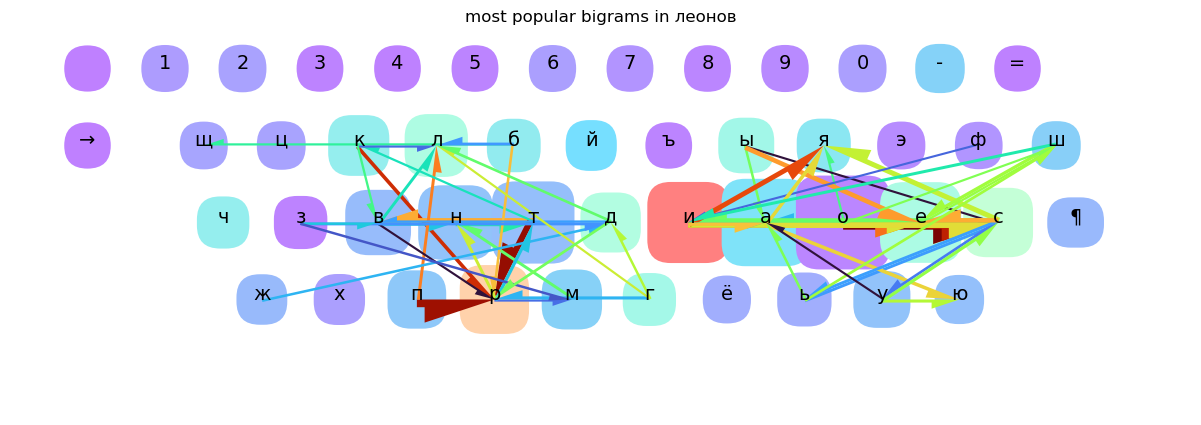

In [42]:
results['леонов'].display('layout', 'num', 'arrows')

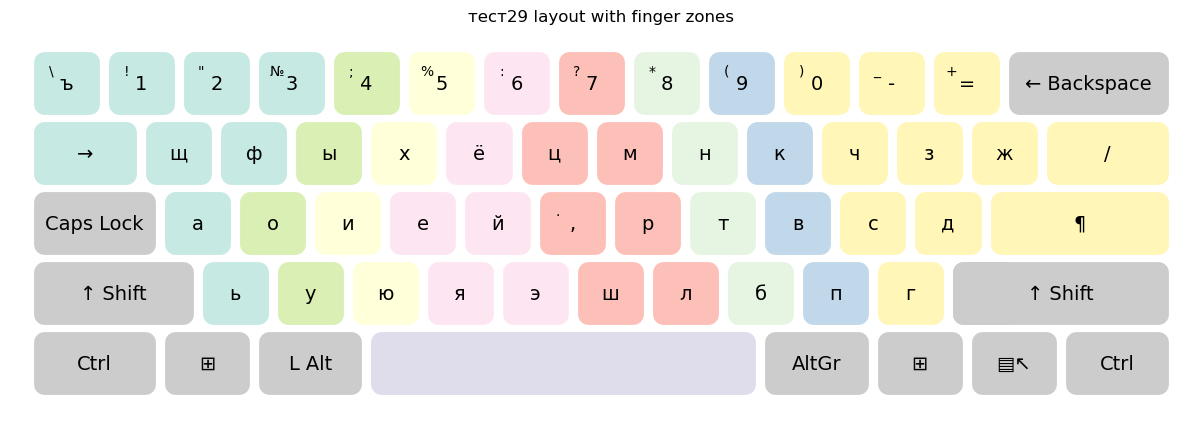

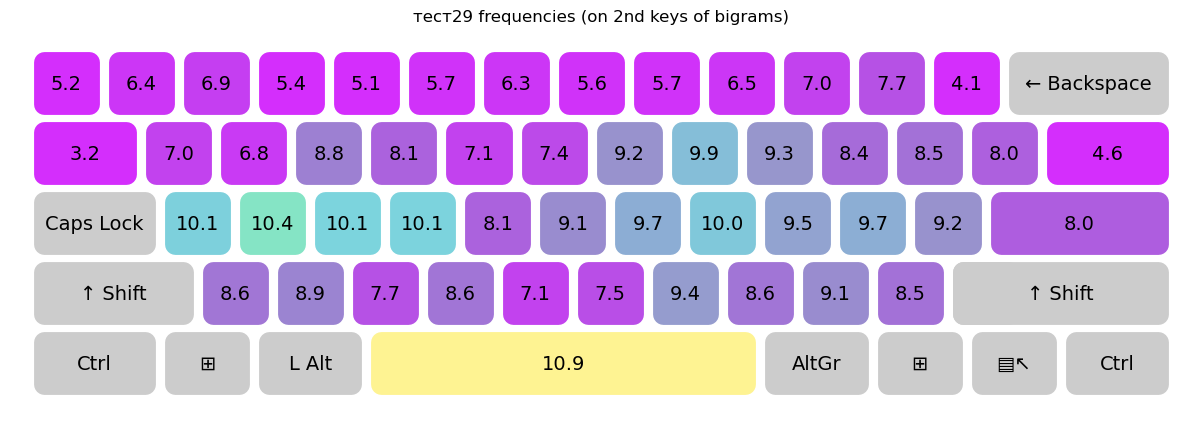

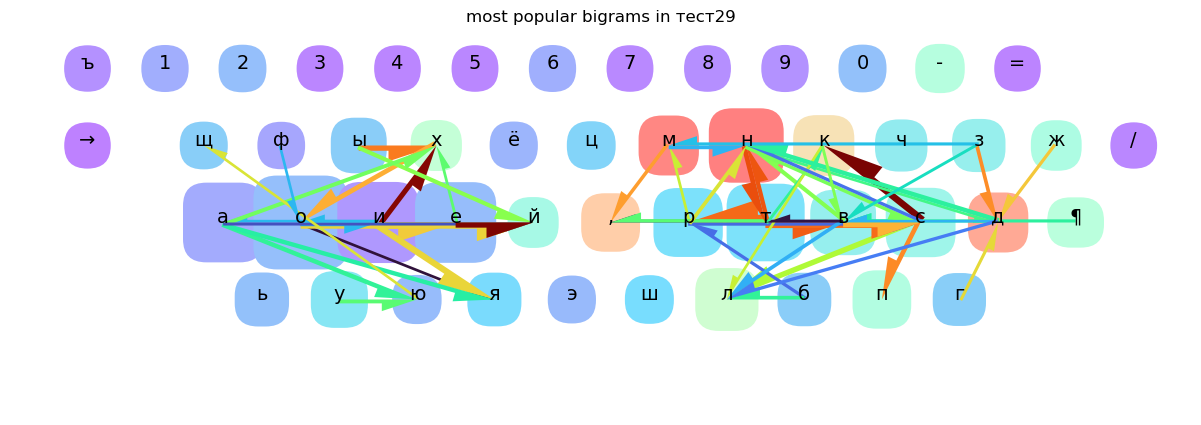

In [43]:
results['тест29'].display('layout', 'num', 'arrows')

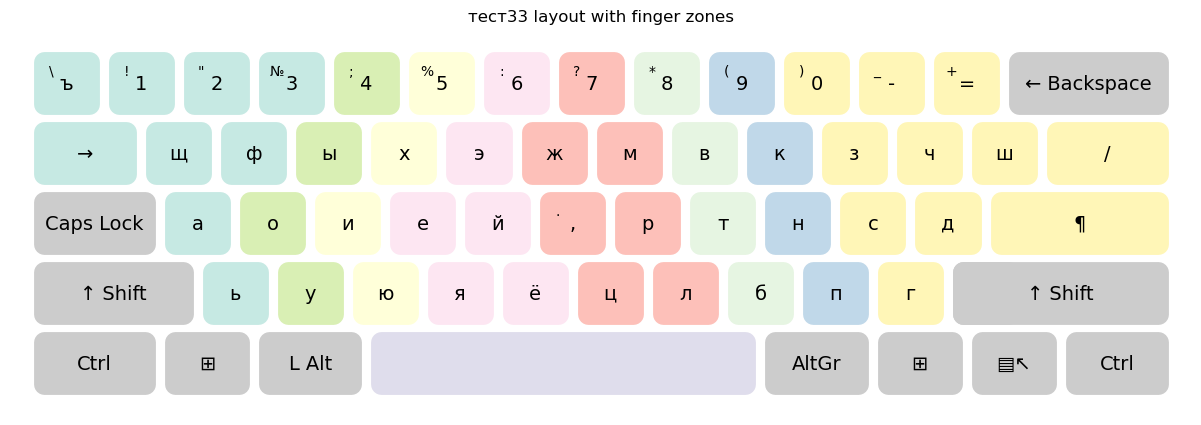

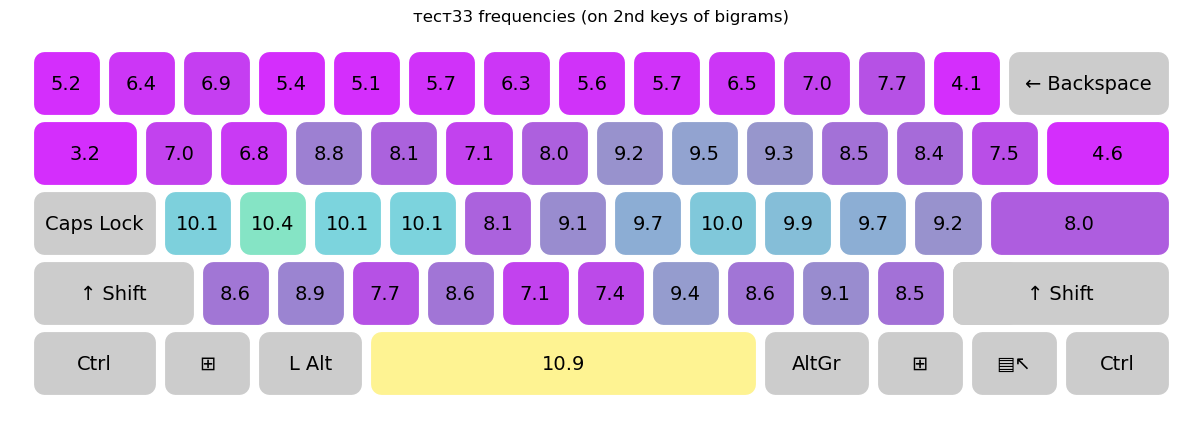

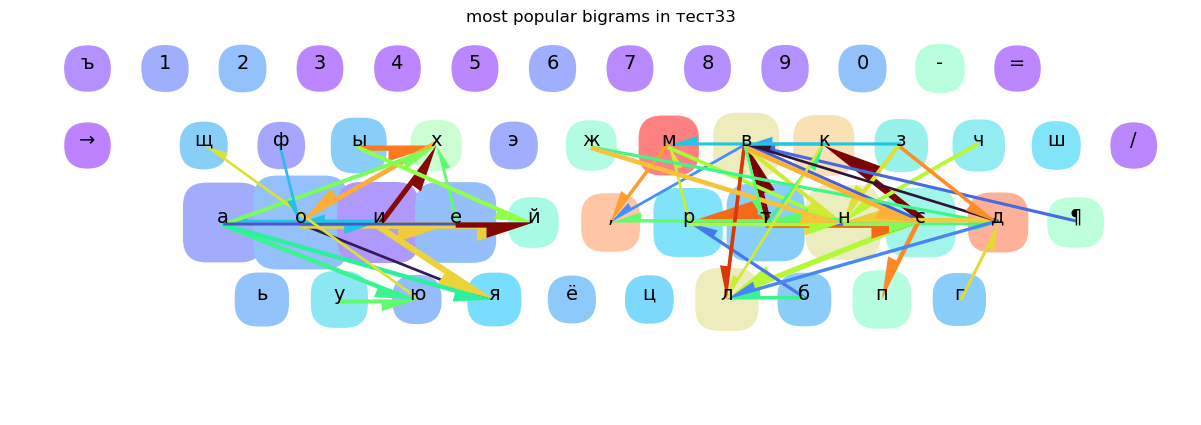

In [44]:
results['тест33'].display('layout', 'num', 'arrows')

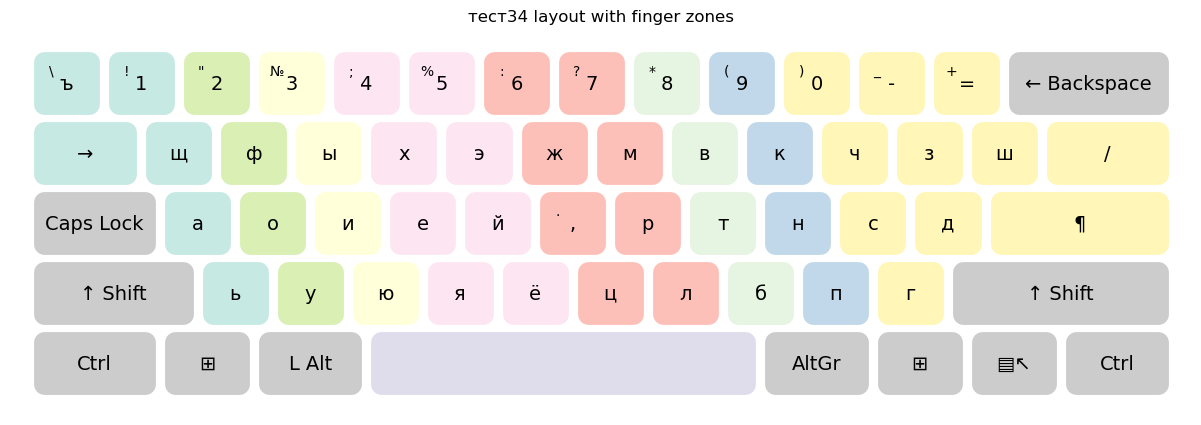

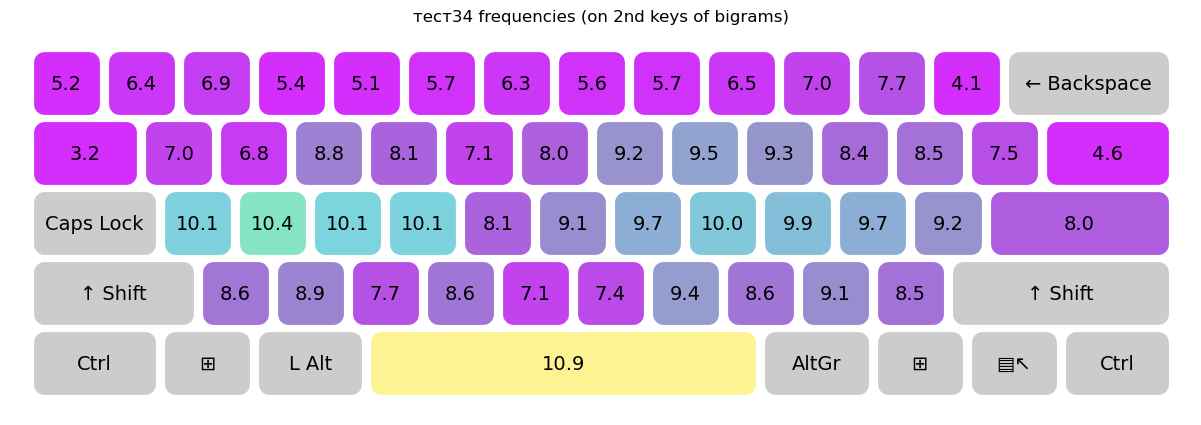

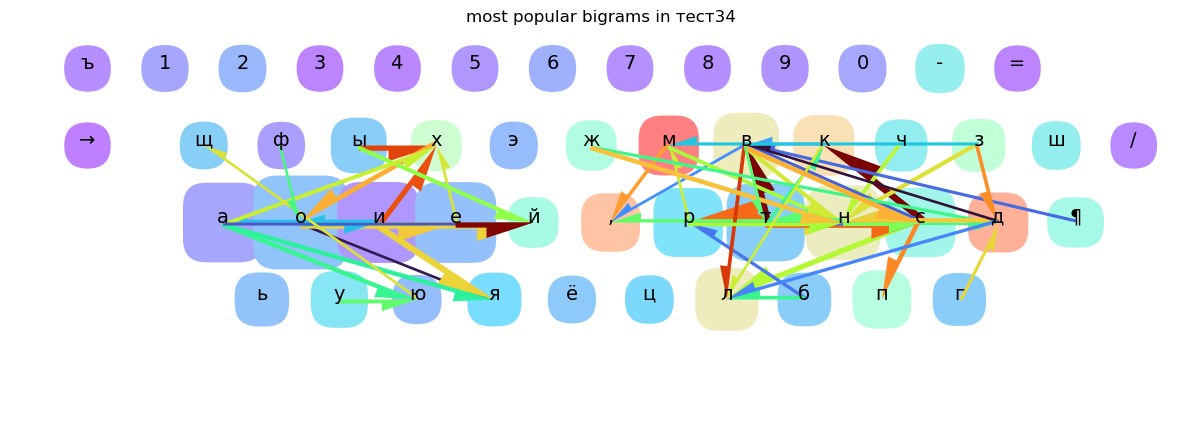

In [45]:
r.display('layout', 'num', 'arrows')

# Comparison of best others' and mine

In [46]:
r = compare(results, 'леонов', 'тест32')
r.head(30)

bigram   num                     category_old  price_old  cost_old  \
55      по  3115                     altern hands          0         0   
114     ск  1284                     altern hands          1      1284   
18      ⌴в  4955                        space bar          0         0   
177     .¶  1085                     altern hands          2      2170   
194     хо   684                     altern hands          0         0   
130     тс   879                     altern hands          0         0   
262     ия  1139             out, over one finger          5      5695   
71      ых   829                     altern hands          1       829   
338     вл   403  in, adj finger, same or adj row          3      1209   
35      ов  3193                     altern hands          0         0   
296     ей   790                     altern hands          4      3160   
111     их   776                     altern hands          1       776   
182     ⌴э   983                        space bar          1       983   
303     па   477                     altern hands          0         0   
49      тв   926             out, over one finger          4      3704   
94      ⌴з  1384                        space bar          0         0   
465     вс   674                     altern hands          0         0   
38      ть  2493                     altern hands          1      2493   
447     зд   390      in, over 1 finger, same row          2       780   
295     оп   568                     altern hands          1       568   
116     аз  1101                     altern hands          0         0   
196     зн   529      in, over 1 finger, same row          0         0   
53      ¶¶  1033                         same key          2      2066   
46      ль  2056                     altern hands          1      2056   
498     зм   290       in, over 1 finger, adj row          2       580   
291     ап   336                     altern hands          1       336   
64      из   970                     altern hands          0         0   
274     ах   479                     altern hands          1       479   
387     жн   625       in, over 1 finger, adj row          1       625   
188     бщ   231                   index -> pinky          6      1386   

                  category_new  price_new  cost_new  delta  
55              ring <-> pinky          4     12460  12460  
114             ring <-> pinky          5      6420   5136  
18                   space bar          1      4955   4955  
177             index -> pinky          6      6510   4340  
194        same finger adj row          6      4104   4104  
130       out, over one finger          4      3516   3516  
262        same finger adj row          8      9112   3417  
71              ring <-> pinky          5      4145   3316  
338        adj finger over row         11      4433   3224  
35                altern hands          1      3193   3193  
296        same finger adj row          8      6320   3160  
111       out, over one finger          5      3880   3104  
182                  space bar          4      3932   2949  
303        same finger adj row          6      2862   2862  
49         same finger adj row          7      6482   2778  
94                   space bar          2      2768   2768  
465       out, over one finger          4      2696   2696  
38                altern hands          2      4986   2493  
447        same finger adj row          8      3120   2340  
295             ring <-> pinky          5      2840   2272  
116               altern hands          2      2202   2202  
196             ring <-> pinky          4      2116   2116  
53                    same key          4      4132   2066  
46                altern hands          2      4112   2056  
498  over 1 finger, over 1 row          9      2610   2030  
291        same finger adj row          7      2352   2016  
64                altern hands          2      1940   1940  
2

In [47]:
r.tail(30)

bigram   num                     category_old  price_old  cost_old  \
236     ны  2235                     altern hands          3      6705   
491     гл   227              adj finger over row         11      2497   
129     ае   572             out, over one finger          4      2288   
181     ой  1149                     altern hands          4      4596   
155     ие  1197             out, over one finger          4      4788   
110     ки  1228                     altern hands          2      2456   
147     ми  1241                     altern hands          2      2482   
156     ис  1273                   index -> pinky          2      2546   
69      ор  2584                     altern hands          1      2584   
184     ое   665             out, over one finger          4      2660   
238     ас  1409                   index -> pinky          2      2818   
133     ⌴ч  1466                        space bar          4      5864   
256     ые   996             out, over one finger          4      3984   
324     бр   308              adj finger over row         11      3388   
187     об  1698                     altern hands          3      5094   
225     ⌴б  1717                        space bar          3      5151   
28      ри  1724                     altern hands          2      3448   
404     се   934                   ring <-> pinky          4      3736   
33      ти  1934                     altern hands          2      3868   
252     пл   410              adj finger over row         11      4510   
79      ⌴г  1384                        space bar          4      5536   
153     ог  1500                     altern hands          4      6000   
7       ли  2626                     altern hands          2      5252   
78      тр  1768             out, over one finger          5      8840   
31      кр   615              adj finger over row         11      6765   
15      ни  3367                     altern hands          2      6734   
61      ес  1846                   ring <-> pinky          4      7384   
23      ⌴и  4035                        space bar          2      8070   
41      пр  2820  in, adj finger, same or adj row          3      8460   
56      ос  2447             out, over one finger          4      9788   

                        category_new  price_new  cost_new  delta  
236                     altern hands          2      4470  -2235  
491      in, over 1 finger, same row          1       227  -2270  
129      in, over 1 finger, same row          0         0  -2288  
181      in, over 1 finger, same row          2      2298  -2298  
155  in, adj finger, same or adj row          2      2394  -2394  
110                     altern hands          0         0  -2456  
147                     altern hands          0         0  -2482  
156                     altern hands          0         0  -2546  
69                      altern hands          0         0  -2584  
184      in, over 1 finger, same row          0         0  -2660  
238                     altern hands          0         0  -2818  
133                        space bar          2      2932  -2932  
256       in, over 1 finger, adj row          1       996  -2988  
324       in, over 1 finger, adj row          1       308  -3080  
187                     altern hands          1      1698  -3396  
225                        space bar          1      1717  -3434  
28                      altern hands          0         0  -3448  
404                     altern hands          0         0  -3736  
33                      altern hands          0         0  -3868  
252                     altern hands          1       410  -4100  
79                         space bar          1      1384  -4152  
153                     altern hands          1      1500  -4500  
7                       altern hands          0         0  -5252  
78   in, adj finger, same or adj row          2      3536  -5304  
31        in, over 1 finger, adj r

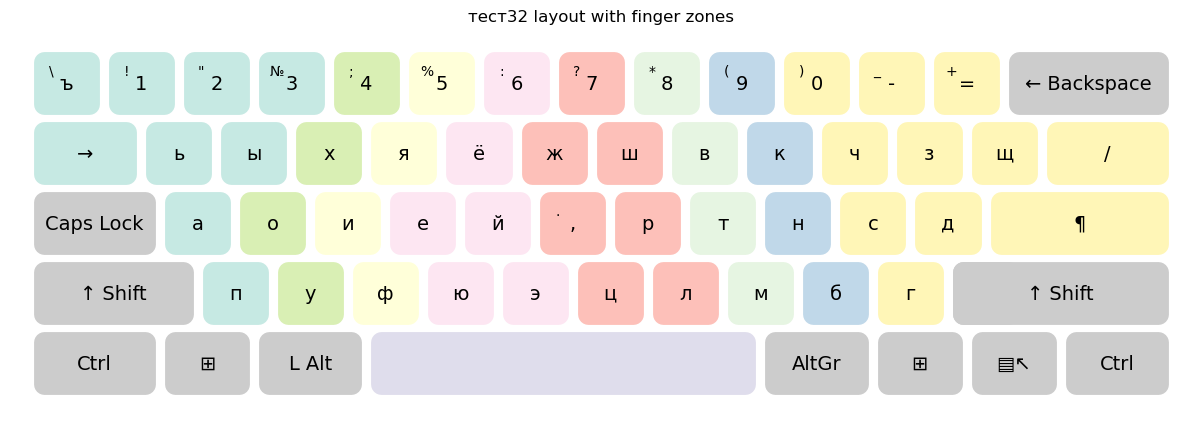

In [48]:
results['тест32'].layout.display()

<AxesSubplot: title={'center': 'тест32 frequencies (on 2nd keys of bigrams)'}>

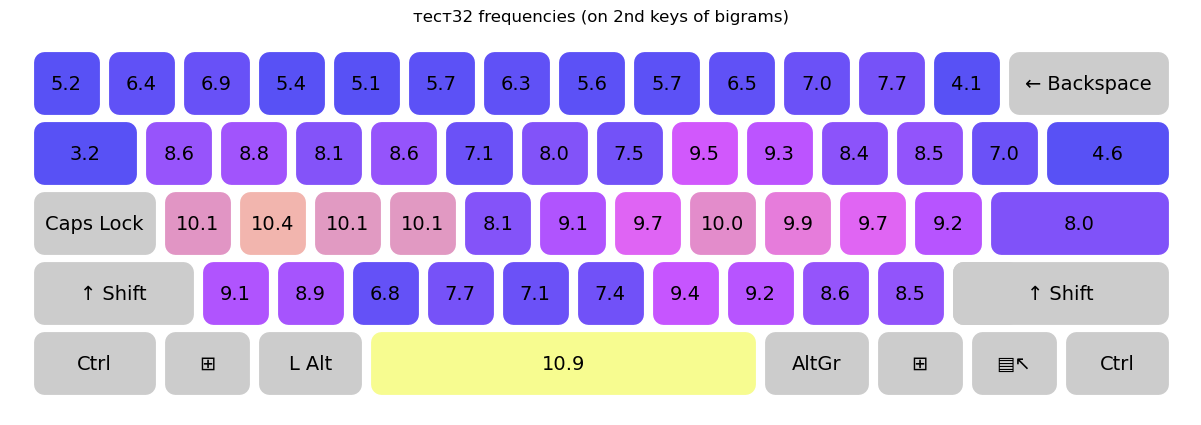

In [49]:
self = results['тест32']
total = self.bigrams['num'].sum()

nums = self.bigrams.groupby(['row', 'column']).agg({'num': 'sum'})['num']

min_num = nums.min()
max_num = nums.max()
colors = nums.apply(color_scale, args=(min_num, max_num))
self.layout.keyboard.raw_display(
    np.log(nums).round(1).to_dict(), colors.to_dict(), f'{self.layout.name} frequencies (on 2nd keys of bigrams)'
)
